In [1]:
# TODO
# Visualizing the demand?
# Share of annual output per storage technology
# more comprehensive correlation analysis: n technologies with most generation / consumption and their generation and capacity correlation

## Imports

In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import pypsa
import math
import seaborn as sns
import cartopy
import cartopy.crs as ccrs
import matplotlib
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from shapely.geometry import Point, LineString
from datetime import datetime
import matplotlib.patheffects as pe
import matplotlib.colors as mcolors

from datetime import date, datetime, time, timedelta

# imported own functions
from utils import market_values, market_values_by_time_index, nodal_balance, capacity, capacity_links, capacity_storage_units, get_condense_sum, nodal_balance, generation, generation_links, generation_storage_units, market_values_storage_units, market_values_links, time_stored_LIFO

# imported own definitions
from utils import carrier_colors, carrier_renaming, carrier_renaming_reverse, resistive_heater, gas_boiler, heat_pump, water_tanks_charger, water_tanks_discharger, solar_thermal

# general variables
font1 = {'fontname':'Calibri'}
PLOT_DIR = 'C:/Users/Julian/Studies/Master/01 TU Berlin/3. Semester - Masterarbeit/MA Marktwerte FEE/data/plots/'
onshore_regions = gpd.read_file("../data/external/regions_onshore_elec_s_181.geojson")
offshore_regions = gpd.read_file("../data/external/regions_offshore_elec_s_181.geojson")
onshore_regions = onshore_regions.set_index('name')
offshore_regions = offshore_regions.set_index('name')

In [3]:
# Network imports
n_no =pypsa.Network("../data/raw/elec_s_181_lv1.0__Co2L0-3H-T-H-B-I-A-solar+p3-linemaxext10-noH2network_2030.nc")
n_h2 =pypsa.Network("../data/raw/elec_s_181_lvopt__Co2L0-3H-T-H-B-I-A-solar+p3-linemaxext10_2030.nc")

Importing PyPSA from older version of PyPSA than current version.
Please read the release notes at https://pypsa.readthedocs.io/en/latest/release_notes.html
carefully to prepare your network for import.
Currently used PyPSA version [0, 20, 1], imported network file PyPSA version [0, 18, 1].

INFO:pypsa.io:Imported network elec_s_181_lv1.0__Co2L0-3H-T-H-B-I-A-solar+p3-linemaxext10-noH2network_2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
Importing PyPSA from older version of PyPSA than current version.
Please read the release notes at https://pypsa.readthedocs.io/en/latest/release_notes.html
carefully to prepare your network for import.
Currently used PyPSA version [0, 20, 1], imported network file PyPSA version [0, 18, 1].

INFO:pypsa.io:Imported network elec_s_181_lvopt__Co2L0-3H-T-H-B-I-A-solar+p3-linemaxext10_2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [4]:
# Notebook Definitions
c1_groups = [resistive_heater, gas_boiler, heat_pump, water_tanks_charger, water_tanks_discharger, solar_thermal]
c1_groups_name = ["resistive heater", "gas boiler", "heat pump", "water tanks charger", "water tanks discharger", "solar thermal"]
markers =["v", "^", "<", ">", "1", "2", "3", "4", "*", "+", "d", "o", "|", "s", "P", "p", "h"]

In [5]:
# Notebook Functions

def get_df(df_no, df_h2, carriers):
    result = pd.DataFrame(index = ["STST", "EXP"])

    for c in carriers:
        result.loc["STST" , c] = df_no[c].values
        result.loc["EXP" , c] = df_h2[c].values
    return result

def c_gen(carrier_list, network):
    result = []
    for c in carrier_list:
        if c in network.generators.carrier.unique().tolist():
            result.append(c)
    return result

def c_link(carrier_list, network):
    result = []
    for c in carrier_list:
        if c in network.links.carrier.unique().tolist():
            result.append(c)
    return result

def c_su(carrier_list, network):
    result = []
    for c in carrier_list:
        if c in network.storage_units.carrier.unique().tolist():
            result.append(c)
    return result

In [6]:
# Regions

onshore_regions['coords'] = onshore_regions['geometry'].apply(lambda x: x.representative_point().coords[:])
onshore_regions['coords'] = [coords[0] for coords in onshore_regions['coords']]
onshore_regions["name"] = onshore_regions.index
offshore_regions['coords'] = offshore_regions['geometry'].apply(lambda x: x.representative_point().coords[:])
offshore_regions['coords'] = [coords[0] for coords in offshore_regions['coords']]
offshore_regions["name"] = offshore_regions.index

## CALC

In [7]:
# calc market values, generation, lmps, capacity factors for generators, links and storage units

for n in [n_no, n_h2]:
    df_regions_onshore = onshore_regions.copy()
    df_regions_offshore = offshore_regions.copy()

    # function for carriers in n.generators.carrier.unique() #13
    for carrier in n.generators.carrier.unique():
        df_regions_onshore[f"{carrier}_mv"] = market_values(n, carrier)
        df_regions_offshore[f"{carrier}_mv"] = market_values(n, carrier)
        # generation in TWh (does this have to be multiplied by 3??
        df_regions_onshore[f"{carrier}_gen"] = generation(n, carrier) / 1000
        df_regions_offshore[f"{carrier}_gen"] = generation(n, carrier) / 1000
        # lmps
        # capacity factors This calculation is correct? as capacity is multiplied by 2920 is the same as multiplying the generation by 3 and then dividing it by the capacity times 8760 (as cap is in MWh?)
        df_regions_onshore[f"{carrier}_cf"] = generation(n, carrier) / (capacity(n, carrier) *2920)
        df_regions_offshore[f"{carrier}_cf"] = generation(n, carrier) / (capacity(n, carrier) *2920)


    # function for carriers in n.links.carrier.unique() #53
    for carrier in n.links.carrier.unique():
        df_regions_onshore[f"{carrier}_mv"] = market_values_links(n, carrier)
        df_regions_onshore[f"{carrier}_gen"] = generation_links(n, carrier) / 1000
        df_regions_onshore[f"{carrier}_cf"] = generation_links(n, carrier) / (capacity_links(n, carrier) *2920)

    # function for carriers in n.storage_units.carrier.unique() #2
    for carrier in n.storage_units.carrier.unique():
        df_regions_onshore[f"{carrier}_mv"] = market_values_storage_units(n, carrier)
        df_regions_onshore[f"{carrier}_gen"] = generation_storage_units(n, carrier) / 1000
        # capacity factors (both generation and consumption(loading) is considered
        gen = abs(n.storage_units_t.p.loc[:, n.storage_units.carrier == carrier])
        gen.columns = gen.columns.map(n.storage_units.bus)
        gen.columns = gen.columns.map(n.buses.location)
        df_regions_onshore[f"{carrier}_cf"] = gen.sum() / (capacity_storage_units(n, carrier) *2920)

    # set market values to nan where generation in corresponding region is lower than % quantile
    qt = 0.2
    for carrier in (n.generators.carrier.unique().tolist() +
                    n.links.carrier.unique().tolist() +
                    n.storage_units.carrier.unique().tolist()):
        index = df_regions_onshore[f"{carrier}_gen"] <= np.quantile(df_regions_onshore[f"{carrier}_gen"], qt)
        df_regions_onshore[f"{carrier}_mv"][index] = np.nan

    # calc lmps at the buses (lmps that are only present for EU (e.g. oil) are nan at the moment)
    # TODO: decide if EU lmps are used as lmp for all regions
    for carrier_bus in n.buses.carrier.unique():
        # index would be same names as the bus (not the location as it is in the index of
        # df_regions_onshore so far -> map location to make sure the right lmp is set
        locs = n.buses.location[n.buses[n.buses.carrier == carrier_bus].index]
        lmps = n.buses_t.marginal_price[n.buses[n.buses.carrier == carrier_bus].index].mean()
        df = pd.concat([lmps, locs], axis=1).rename(columns={0: f"{carrier_bus}_lmp"})
        df.set_index("location", inplace=True)
        if df.size == 1:
            if df.index == "EU":
                df = pd.DataFrame(np.repeat(df.values, 181), index=df_regions_onshore.index, columns=[f"{carrier_bus}_lmp"])
                df_regions_onshore[f"{carrier_bus}_lmp"] = df[f"{carrier_bus}_lmp"]
        else:
            df_regions_onshore[f"{carrier_bus}_lmp"] = df[f"{carrier_bus}_lmp"]

    if n == n_no:
        df_no_ons = df_regions_onshore
        df_no_off = df_regions_offshore

    if n == n_h2:
        df_h2_ons = df_regions_onshore
        df_h2_off = df_regions_offshore

df_no_ons.head()

geometry  \
name                                                       
AL0 0  POLYGON ((20.32207 39.91318, 20.39703 39.81809...   
AT0 0  POLYGON ((16.45660 47.41184, 16.43396 47.39685...   
AT0 1  POLYGON ((10.08288 47.35907, 10.20928 47.37248...   
AT0 2  POLYGON ((13.47802 46.56357, 13.23111 46.55217...   
BA0 0  POLYGON ((17.82716 42.85312, 17.81176 42.90986...   

                                         coords   name  offwind-ac_mv  \
name                                                                    
AL0 0    (20.00648437943388, 41.14563914300007)  AL0 0     126.148417   
AT0 0  (15.700718667666258, 47.896990619088925)  AT0 0            NaN   
AT0 1   (10.379200993764837, 47.18231496200006)  AT0 1            NaN   
AT0 2   (13.805469952867842, 47.57283376100011)  AT0 2            NaN   
BA0 0    (17.97055162265331, 43.88773569750005)  BA0 0            NaN   

       offwind-ac_gen  offwind-ac_cf  onwind_mv    onwind_gen  onwind_cf  \
name                                                                       
AL0 0        0.009746       0.090705        NaN      0.005042   0.038018   
AT0 0             NaN            NaN  83.457109  10131.968084   0.149667   
AT0 1             NaN            NaN        NaN      0.000116   0.004685   
AT0 2             NaN            NaN        NaN      0.004773   0.039178   
BA0 0             NaN            NaN        NaN      0.004686   0.031802   

        solar_mv  ...  urban central water tanks_lmp  biogas_lmp  \
name              ...                                              
AL0 0  44.628736  ...                      43.532557  113.716896   
AT0 0  54.679083  ...                      55.231280  113.716896   
AT0 1  65.745903  ...                      55.553668  113.716896   
AT0 2  58.223787  ...                      58.936874  113.716896   
BA0 0  51.160537  ...                      51.074197  113.716896   

       solid biomass_lmp  solid biomass for industry_lmp  \
name                                                       
AL0 0         102.453861                       78.924392   
AT0 0         102.453861                       78.924392   
AT0 1         102.453861                       78.924392   
AT0 2         102.453861                       78.924392   
BA0 0         102.453861                       78.924392   

       gas for industry_lmp  H2 liquid_lmp    oil_lmp  process emissions_lmp  \
name                                                                           
AL0 0            113.135704     137.617875  50.009981            -408.520212   
AT0 0            113.135704     151.448316  50.009981            -408.520212   
AT0 1            113.135704     154.026970  50.009981            -408.520212   
AT0 2            113.135704     148.663198  50.009981            -408.520212   
BA0 0            113.135704     147.689672  50.009981            -408.520212   

       low voltage_lmp  home battery_lmp  
name                                      
AL0 0       100.338046        100.380697  
AT0 0       115.006246        115.044440  
AT0 1       121.910720        121.947576  
AT0 2       112.352878        112.386673  
BA0 0       112.040690        112.006725  

[5 rows x 233 columns]

In [8]:
# calc market values, generation, lmps, capacity factors for generators, links and storage units
df_regions_onshore = onshore_regions.copy()
df_regions_offshore = offshore_regions.copy()
n = n_h2

# function for carriers in n.generators.carrier.unique() #13
for carrier in n.generators.carrier.unique():
    df_regions_onshore[f"{carrier}_mv"] = market_values(n, carrier)
    df_regions_offshore[f"{carrier}_mv"] = market_values(n, carrier)
    # generation in TWh
    df_regions_onshore[f"{carrier}_gen"] = generation(n, carrier) / 1000
    df_regions_offshore[f"{carrier}_gen"] = generation(n, carrier) / 1000
    # lmps
    df_regions_onshore[f"{carrier}_gen"] = generation(n, carrier) / 1000
    df_regions_offshore[f"{carrier}_gen"] = generation(n, carrier) / 1000

# function for carriers in n.links.carrier.unique() #53
for carrier in n.links.carrier.unique():
    df_regions_onshore[f"{carrier}_mv"] = market_values_links(n, carrier)
    df_regions_onshore[f"{carrier}_gen"] = generation_links(n, carrier) / 1000

# function for carriers in n.storage_units.carrier.unique() #2
for carrier in n.storage_units.carrier.unique():
    df_regions_onshore[f"{carrier}_mv"] = market_values_storage_units(n, carrier)
    df_regions_onshore[f"{carrier}_gen"] = generation_storage_units(n, carrier) / 1000

# set market values to nan where generation in corresponding region is lower than % quantile
qt = 0.2
for carrier in (n.generators.carrier.unique().tolist() +
                n.links.carrier.unique().tolist() +
                n.storage_units.carrier.unique().tolist()):
    index = df_regions_onshore[f"{carrier}_gen"] <= np.quantile(df_regions_onshore[f"{carrier}_gen"], qt)
    df_regions_onshore[f"{carrier}_mv"][index] = np.nan

# calc lmps at the buses (lmps that are only present for EU (e.g. oil) are nan at the moment)
# TODO: decide if EU lmps are used as lmp for all regions
for carrier_bus in n.buses.carrier.unique():
    # index would be same names as the bus (not the location as it is in the index of
    # df_regions_onshore so far -> map location to make sure the right lmp is set
    locs = n.buses.location[n.buses[n.buses.carrier == carrier_bus].index]
    lmps = n.buses_t.marginal_price[n.buses[n.buses.carrier == carrier_bus].index].mean()
    df = pd.concat([lmps, locs], axis=1).rename(columns={0: f"{carrier_bus}_lmp"})
    df.set_index("location", inplace=True)
    if df.size == 1:
        if df.index == "EU":
            df = pd.DataFrame(np.repeat(df.values, 181), index=df_regions_onshore.index, columns=[f"{carrier_bus}_lmp"])
            df_regions_onshore[f"{carrier_bus}_lmp"] = df[f"{carrier_bus}_lmp"]
    else:
        df_regions_onshore[f"{carrier_bus}_lmp"] = df[f"{carrier_bus}_lmp"]

df_regions_onshore.head(3)
# df_regions_offshore.head(3)

df_h2_ons = df_regions_onshore
df_h2_off = df_regions_offshore

In [9]:
#assert 0

# 4.1 Overview

## Network Overview

In [10]:
print(n_no)

PyPSA Network
Components:
 - Bus: 3086
 - Carrier: 30
 - Generator: 1707
 - GlobalConstraint: 3
 - Line: 323
 - Link: 8375
 - Load: 2542
 - StorageUnit: 170
 - Store: 1635
Snapshots: 2920


In [11]:
print(n_h2)

PyPSA Network
Components:
 - Bus: 3086
 - Carrier: 30
 - Generator: 1707
 - GlobalConstraint: 2
 - Line: 323
 - Link: 9192
 - Load: 2542
 - StorageUnit: 170
 - Store: 1635
Snapshots: 2920


### Electricity network

In [12]:
m_no = n_no.copy()
m_no.mremove("Bus",m_no.buses[m_no.buses.x == 0].index )

m_h2 = n_h2.copy()
m_h2.mremove("Bus",m_h2.buses[m_h2.buses.x == 0].index )

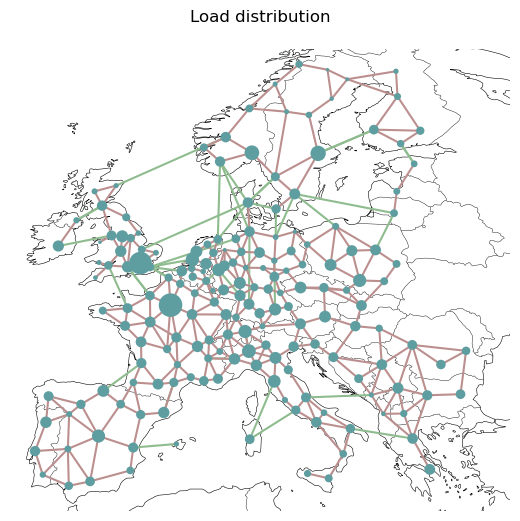

In [13]:
fig, ax = plt.subplots(1, 1, subplot_kw={"projection": ccrs.EqualEarth()}, figsize=(8, 6))

bus_locs = pd.Index(m_no.buses.location.unique())
load_distribution = m_no.loads_t.p[bus_locs].sum()/m_no.loads_t.p[bus_locs].sum().max()

m_no.plot(bus_sizes=1*load_distribution, ax=ax, projection=ccrs.EqualEarth())
ax.set_title("Load distribution", pad=20)
plt.show()
# same for m_h2

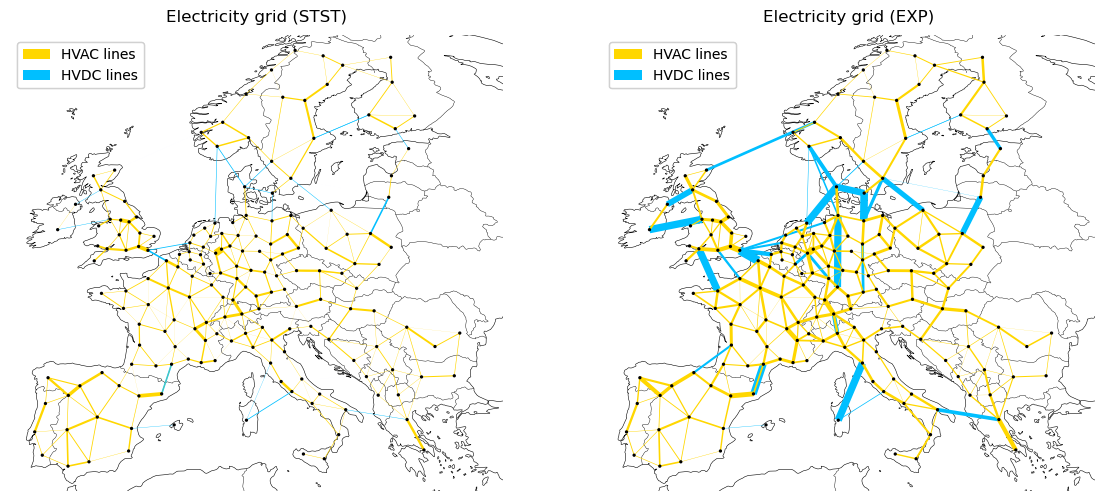

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, subplot_kw={"projection": ccrs.EqualEarth()}, figsize=(14, 10))

# STST
hvac_weights = n_no.lines.s_nom_opt / n_no.lines.s_nom_opt.max() * 5
hvdc_weights = n_no.links.p_nom_opt.replace(0, 1) / n_no.links.p_nom_opt.max() * 50

m_no.plot(ax=ax1, projection=ccrs.EqualEarth(), bus_colors="black", line_colors="gold", link_colors="deepskyblue", line_widths=hvac_weights, link_widths=hvdc_weights )
pypsa.plot.add_legend_patches(ax=ax1, labels=["HVAC lines", "HVDC lines"], colors=["gold","deepskyblue"], legend_kw={'loc': 'upper left'})
ax1.set_title("Electricity grid (STST)", pad=10)

# EXP
hvac_weights = n_h2.lines.s_nom_opt / n_h2.lines.s_nom_opt.max() * 5
hvdc_weights = n_h2.links.p_nom_opt.replace(0, 1) / n_h2.links.p_nom_opt.max() * 50

m_h2.plot(ax=ax2, projection=ccrs.EqualEarth(), bus_colors="black", line_colors="gold", link_colors="deepskyblue", line_widths=hvac_weights, link_widths=hvdc_weights )
pypsa.plot.add_legend_patches(ax=ax2, labels=["HVAC lines", "HVDC lines"], colors=["gold","deepskyblue"], legend_kw={'loc': 'upper left'})
ax2.set_title("Electricity grid (EXP)", pad=10)

plt.show()

In [15]:
# AC lines

In [16]:
# all AC network lines are froms same type
n_no.lines.type.unique()

array(['Al/St 240/40 4-bundle 380.0'], dtype=object)

In [17]:
# Optimised capacity for apparent power: capacities in megavolt amperes (MVA)
n_h2.lines.s_nom_opt.sum()
n_no.lines.s_nom_opt.sum()

1661313.524409717

In [18]:
# sum of all capacities of all AC lines is almost twice as high for the second network
n_h2.lines.s_nom_opt.sum() / n_no.lines.s_nom_opt.sum()

1.936867546113058

In [19]:
# DC cables

In [20]:
n_no.links[n_no.links.carrier == "DC"].p_nom_opt.sum()

16440.0

In [21]:
n_h2.links[n_h2.links.carrier == "DC"].p_nom_opt.sum()

184344.89875153708

In [22]:
n_h2.links[n_h2.links.carrier == "DC"].p_nom_opt.sum() / n_no.links[n_no.links.carrier == "DC"].p_nom_opt.sum()

11.213193354716367

In [23]:
# overall length of network

In [24]:
# AC lines (km)
n_no.lines.length.sum()

68396.95599455902

In [25]:
# DC lines (km)
n_no.links[n_no.links.carrier == "DC"].length.sum()

17893.88200995407

In [26]:
# AC lines (km)
n_h2.lines.length.sum()

68396.95599455902

In [27]:
n_h2.links[n_h2.links.carrier == "DC"].length.sum()

17893.88200995407

Findings:
- electricity network has the same lines in both scenarios, difference is in the capacity
- the lines (AC, DC) also have the same length
- The capacity of the AC lines are twice as high in the h2 case
- The capacity of the DC lines are 11 times higher than in the no case

### Hydrogen network

In [28]:
l_h2 = n_h2.copy()

locs = l_h2.buses[l_h2.buses.carrier == "AC"][["x","y"]]
mapping = pd.DataFrame(l_h2.buses[l_h2.buses.carrier == "H2"].location)
mapping["bus"] = mapping.index
mapping.set_index("location", inplace =True)
locs.index = locs.index.map(mapping.to_dict()['bus'])
l_h2.buses.x[l_h2.buses.carrier == "H2"] = locs.x
l_h2.buses.y[l_h2.buses.carrier == "H2"] = locs.y

l_h2.mremove("Bus",l_h2.buses[l_h2.buses.carrier != "H2"].index)

# write LineStrign into pipes (links)
h2_pipes = l_h2.links[l_h2.links.carrier.isin(["H2 pipeline retrofitted" , "H2 pipeline"])].index
other_links = l_h2.links[-l_h2.links.carrier.isin(["H2 pipeline retrofitted" , "H2 pipeline"])].index

for pipe in h2_pipes:
    loc1 = l_h2.buses.loc[l_h2.links.loc[pipe].bus0][["x", "y"]]
    loc2 = l_h2.buses.loc[l_h2.links.loc[pipe].bus1][["x", "y"]]
    l_h2.links.geometry.loc[pipe] = LineString([Point(loc1), Point(loc2)]).wkt

l_h2.mremove("Link", other_links)
l_h2.mremove("Line", l_h2.lines.index)

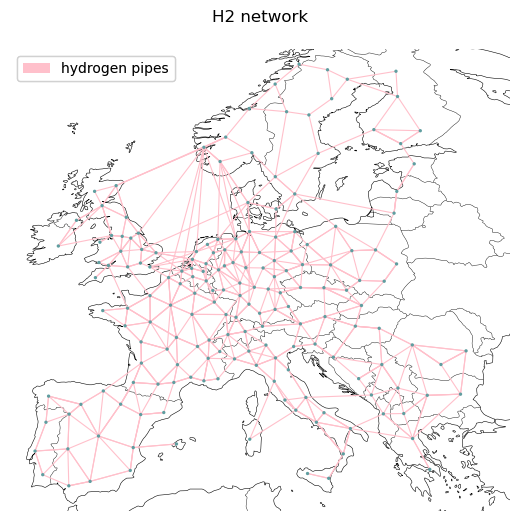

In [29]:
fig, ax = plt.subplots(1, 1, subplot_kw={"projection": ccrs.EqualEarth()}, figsize=(8, 6))

l_h2.plot(ax=ax, link_colors="pink", link_widths=0.8,  projection=ccrs.EqualEarth())
pypsa.plot.add_legend_patches(ax=ax, labels=["hydrogen pipes"], colors=["pink"], legend_kw={'loc': 'upper left'})
ax.set_title("H2 network", pad=20)
plt.show()

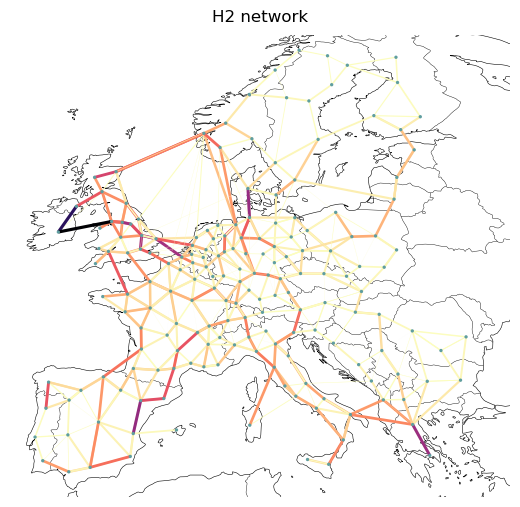

In [30]:
# adding colorbar to this

fig, ax = plt.subplots(1, 1, subplot_kw={"projection": ccrs.EqualEarth()}, figsize=(8, 6))

l_h2.links.p_max_pu
l_h2.plot(ax=ax, link_colors=l_h2.links.p_nom_opt, link_cmap=plt.get_cmap("magma_r"), link_widths=np.log10(l_h2.links.p_nom_opt)/2,  projection=ccrs.EqualEarth())
ax.set_title("H2 network", pad=10)
plt.show()

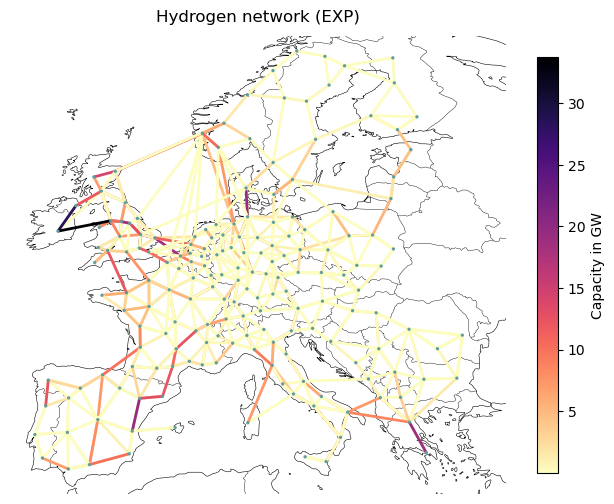

In [31]:
# with colorbar

fig, ax = plt.subplots(1, 1, subplot_kw={"projection": ccrs.EqualEarth()}, figsize=(8, 6))

# GW
link_loading = l_h2.links.p_nom_opt / 1000

cmap= plt.cm.magma_r
norm = mcolors.Normalize(vmin=link_loading.min(), vmax=link_loading.max())
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
colors = list(map(mcolors.to_hex, cmap(norm(link_loading))))

l_h2.plot(ax=ax, link_colors=colors, link_widths=2,  projection=ccrs.EqualEarth())
plt.colorbar(sm, orientation='vertical', shrink=0.9, ax=ax, label="Capacity in GW")
plt.title("Hydrogen network (EXP)", pad=10)

plt.show()

In [32]:
# hydrogen pipeline network in km
n_h2.links[n_h2.links.carrier.isin(["H2 pipeline retrofitted" , "H2 pipeline"])].length.sum()

193545.8096976719

In [33]:
n_h2.links[n_h2.links.carrier.isin(["H2 pipeline retrofitted" , "H2 pipeline"])]

bus0       bus1  \
Link                                                           
H2 pipeline retrofitted AL0 0 -> IT0 10  AL0 0 H2  IT0 10 H2   
H2 pipeline retrofitted AT0 0 -> AT0 2   AT0 0 H2   AT0 2 H2   
H2 pipeline retrofitted AT0 0 -> HU0 0   AT0 0 H2   HU0 0 H2   
H2 pipeline retrofitted AT0 0 -> SK0 0   AT0 0 H2   SK0 0 H2   
H2 pipeline retrofitted AT0 0 <-> AT0 2  AT0 0 H2   AT0 2 H2   
...                                           ...        ...   
H2 pipeline SE3 1 -> SE3 7               SE3 1 H2   SE3 7 H2   
H2 pipeline SE3 2 -> SE3 5               SE3 2 H2   SE3 5 H2   
H2 pipeline SE3 3 -> SE3 6               SE3 3 H2   SE3 6 H2   
H2 pipeline SE3 4 -> SE3 7               SE3 4 H2   SE3 7 H2   
H2 pipeline SE3 5 -> SE3 6               SE3 5 H2   SE3 6 H2   

                                                         carrier geometry  \
Link                                                                        
H2 pipeline retrofitted AL0 0 -> IT0 10  H2 pipeline retrofitted            
H2 pipeline retrofitted AT0 0 -> AT0 2   H2 pipeline retrofitted            
H2 pipeline retrofitted AT0 0 -> HU0 0   H2 pipeline retrofitted            
H2 pipeline retrofitted AT0 0 -> SK0 0   H2 pipeline retrofitted            
H2 pipeline retrofitted AT0 0 <-> AT0 2  H2 pipeline retrofitted            
...                                                          ...      ...   
H2 pipeline SE3 1 -> SE3 7                           H2 pipeline            
H2 pipeline SE3 2 -> SE3 5                           H2 pipeline            
H2 pipeline SE3 3 -> SE3 6                           H2 pipeline            
H2 pipeline SE3 4 -> SE3 7                           H2 pipeline            
H2 pipeline SE3 5 -> SE3 6                           H2 pipeline            

                                             length  p_nom  \
Link                                                         
H2 pipeline retrofitted AL0 0 -> IT0 10  254.011781    0.0   
H2 pipeline retrofitted AT0 0 -> AT0 2   228.454388    0.0   
H2 pipeline retrofitted AT0 0 -> HU0 0   274.453912    0.0   
H2 pipeline retrofitted AT0 0 -> SK0 0   372.071027    0.0   
H2 pipeline retrofitted AT0 0 <-> AT0 2  228.454388    0.0   
...                                             ...    ...   
H2 pipeline SE3 1 -> SE3 7               272.988128    0.0   
H2 pipeline SE3 2 -> SE3 5               141.983342    0.0   
H2 pipeline SE3 3 -> SE3 6               222.522966    0.0   
H2 pipeline SE3 4 -> SE3 7               161.813506    0.0   
H2 pipeline SE3 5 -> SE3 6               751.431228    0.0   

                                                                                      tags  \
Link                                                                                         
H2 pipeline retrofitted AL0 0 -> IT0 10                 INET_PL_669_EE_0_Seg_0_Seg_0_Seg_0   
H2 pipeline retrofitted AT0 0 -> AT0 2                                PLS_6292_Seg_0_Seg_0   
H2 pipeline retrofitted AT0 0 -> HU0 0   ST_929_Seg_0_Seg_0_Seg_1 PLS_4606_Seg_0_Seg_0_...   
H2 pipeline retrofitted AT0 0 -> SK0 0                            EntsoG_Map__ST_423_Seg_0   
H2 pipeline retrofitted AT0 0 <-> AT0 2                          PLL_709_Seg_0_Seg_0_Seg_3   
...                                                                                    ...   
H2 pipeline SE3 1 -> SE3 7                                                                   
H2 pipeline SE3 2 -> SE3 5                                                                   
H2 pipeline SE3 3 -> SE3 6                                                                   
H2 pipeline SE3 4 -> SE3 7                                                                   
H2 pipeline SE3 5 -> SE3 6                                                                   

                                         under_construction  underground  \
Link                                                                       
H2 pipeline retrofitted AL0 

## Installed Capacity, Generation, Consumption

In [34]:
cap_no = pd.DataFrame(index=n_no.buses.location.unique())
cap_h2 = pd.DataFrame(index=n_h2.buses.location.unique())

for n, df in zip([n_no, n_h2], [cap_no,cap_h2]):

    for c in n.generators.carrier.unique():
        # capacity in GW
        df[c] = capacity(n, c) / 1000

    for c in n.links.carrier.unique():
        # capacity in GW
        df[c] = capacity_links(n, c) / 1000

    for c in n.storage_units.carrier.unique():
        # capacity in GW
        df[c] = capacity_storage_units(n, c) / 1000

# condense groups
cap_no = get_condense_sum(cap_no, c1_groups, c1_groups_name)
cap_h2 = get_condense_sum(cap_h2, c1_groups, c1_groups_name)
# rename unhandy column names
cap_no.rename(columns=carrier_renaming, inplace=True)
cap_h2.rename(columns=carrier_renaming, inplace=True)

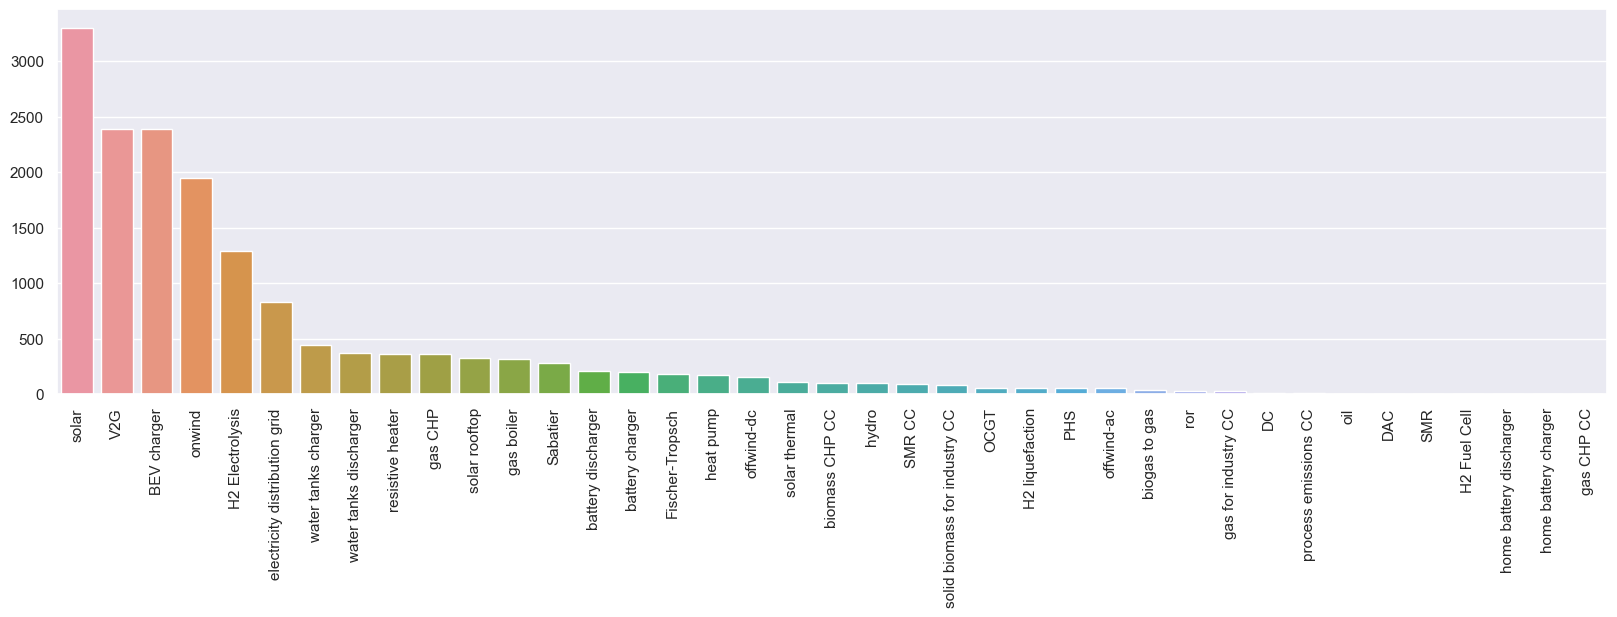

In [35]:
cap_no_sum = pd.DataFrame(cap_no.sum().sort_values(ascending=False)).transpose()
sns.set(rc={'figure.figsize': (20, 5)})
sns.barplot(data=cap_no_sum.iloc[: , 1:40])
ticks = plt.xticks(rotation=90)
plt.show()

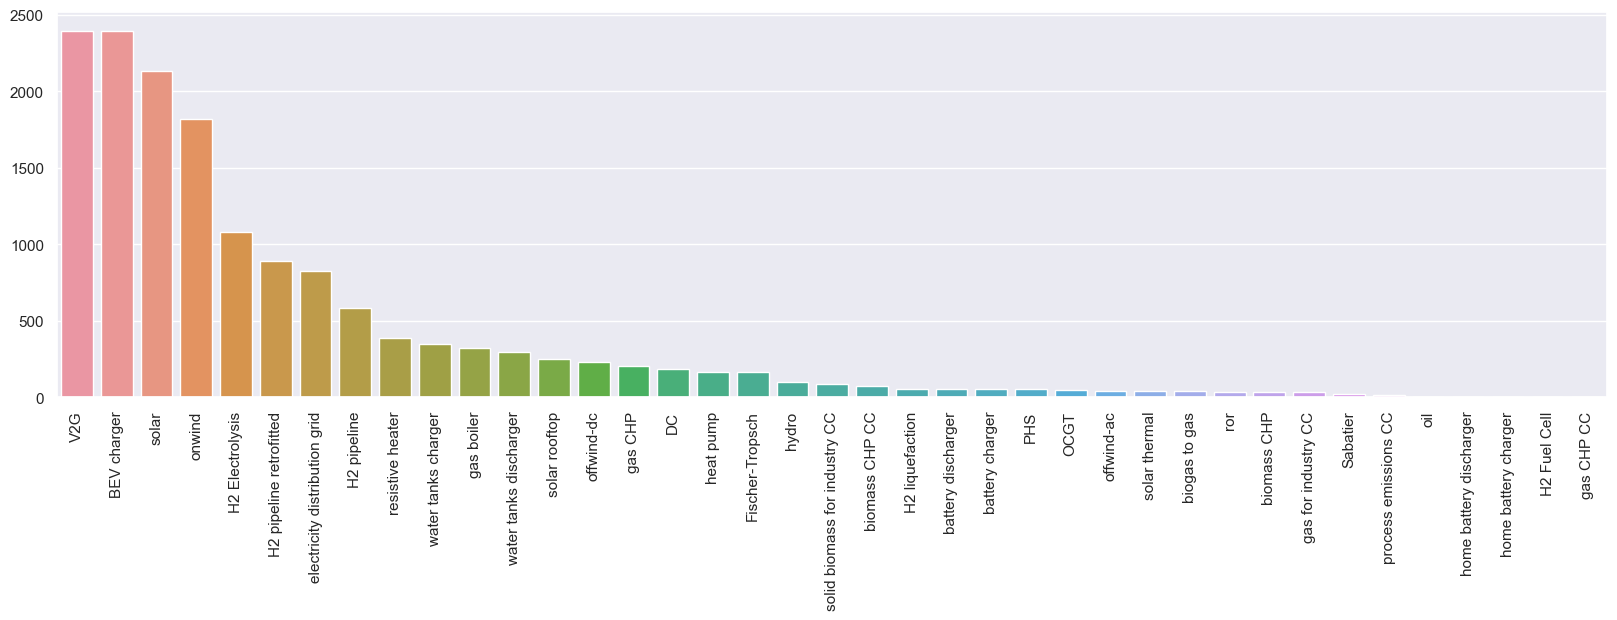

In [36]:
cap_h2_sum = pd.DataFrame(cap_h2.sum().sort_values(ascending=False)).transpose()
sns.set(rc={'figure.figsize': (20, 5)})
sns.barplot(data=cap_h2_sum.iloc[: , 1:40])
ticks = plt.xticks(rotation=90)
plt.show()

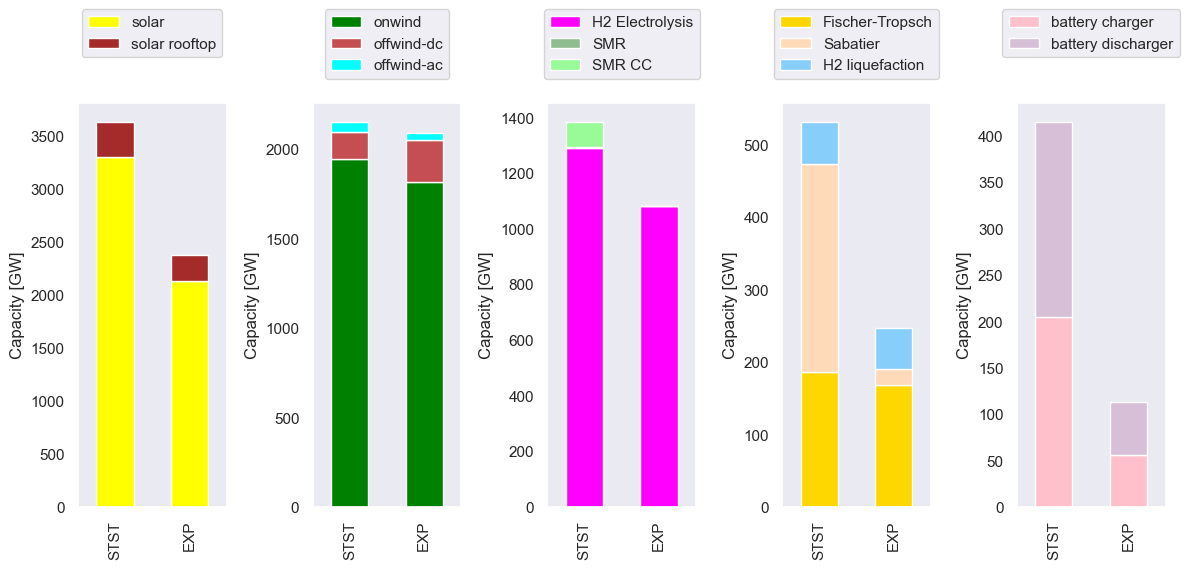

In [37]:
# thesis_plot
# capacity of important technologies

fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=5, figsize=(12, 6))
bbox = (0.5, 1.25)

carriers = ["solar" , "solar rooftop"]
get_df(cap_no_sum, cap_h2_sum, carriers).plot(ax = ax0, kind="bar", stacked=True, grid=False, color=[carrier_colors[c] for c in carriers], ylabel="Capacity [GW]")
ax0.legend(loc='upper center', bbox_to_anchor=bbox)

carriers = ["onwind", "offwind-dc", "offwind-ac"]
get_df(cap_no_sum, cap_h2_sum, carriers).plot(ax = ax1, kind="bar", stacked=True, grid=False, color=[carrier_colors[c] for c in carriers], ylabel="Capacity [GW]")
ax1.legend(loc='upper center', bbox_to_anchor=bbox)

carriers = ["H2 Electrolysis", "SMR", "SMR CC"]
get_df(cap_no_sum, cap_h2_sum, carriers).plot(ax = ax2, kind="bar", stacked=True, grid=False, color=[carrier_colors[c] for c in carriers], ylabel="Capacity [GW]")
ax2.legend(loc='upper center', bbox_to_anchor=bbox)

carriers = ["Fischer-Tropsch", "Sabatier", "H2 liquefaction"]
get_df(cap_no_sum, cap_h2_sum, carriers).plot(ax = ax3, kind="bar", stacked=True, grid=False, color=[carrier_colors[c] for c in carriers], ylabel="Capacity [GW]")
ax3.legend(loc='upper center', bbox_to_anchor=bbox)

carriers = ["battery charger", "battery discharger"]
get_df(cap_no_sum, cap_h2_sum, carriers).plot(ax = ax4, kind="bar", stacked=True, grid=False, color=[carrier_colors[c] for c in carriers], ylabel="Capacity [GW]")
ax4.legend(loc='upper center', bbox_to_anchor=bbox)

fig.tight_layout()
plt.show()

# fig.savefig(f"{PLOT_DIR}01_general/4.1_system_overview/capa_scenarios.png")

In [38]:
carriers = ["hydro"]
get_df(cap_no_sum, cap_h2_sum, carriers)

hydro
STST  99.562201
EXP   99.562201

In [39]:
# magnitude is in GW
carriers = ["battery charger", "battery discharger"]
round(get_df(cap_no_sum, cap_h2_sum, carriers), 0).transpose() / round(get_df(cap_no_sum, cap_h2_sum, carriers), 0).transpose().sum()
# round(get_df(cap_no_sum, cap_h2_sum, carriers), 0).sum(axis=1)

STST       EXP
battery charger     0.493976  0.495575
battery discharger  0.506024  0.504425

In [40]:
# magnitude is in GW
carriers = ["H2 Fuel Cell"]
round(get_df(cap_no_sum, cap_h2_sum, carriers), 0).transpose()
# round(get_df(cap_no_sum, cap_h2_sum, carriers), 0).sum(axis=1)

STST  EXP
H2 Fuel Cell   1.0  0.0


Notes:
- 'H2 pipeline', 'H2 pipeline retrofitted' are the only difference in the carriers (n_no does not have them)
- H2 Fuel Cell Capacity is not really existent: capacity without H2 network is 1 GW and with H2 network it is 0


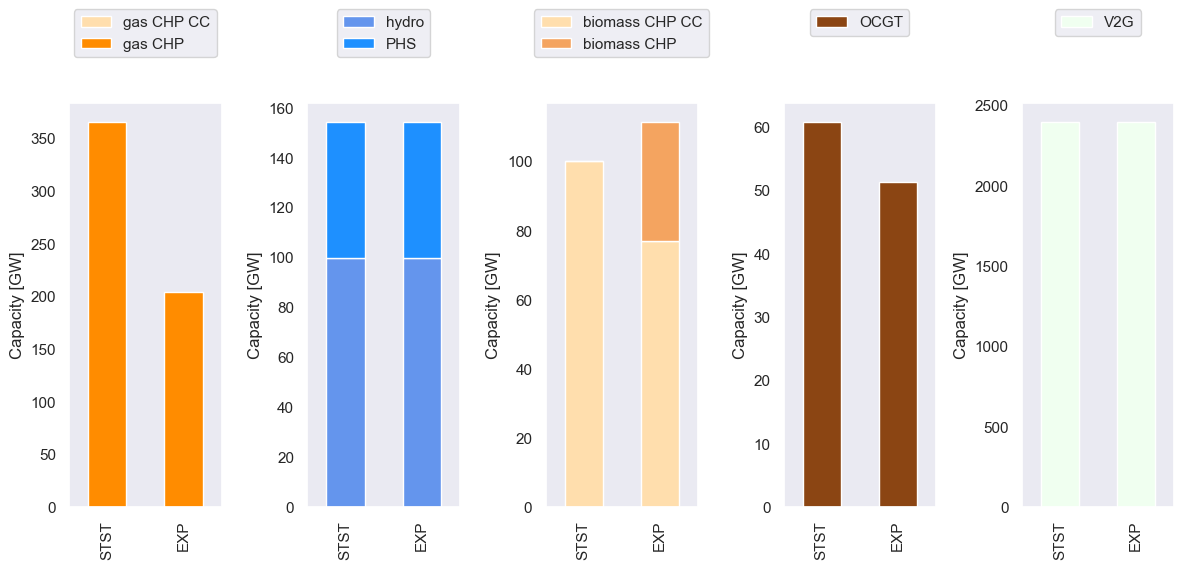

In [41]:
# capacity of peak power plants

fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=5, figsize=(12, 6))
bbox = (0.5, 1.25)

carriers = ["gas CHP CC", "gas CHP"]
get_df(cap_no_sum, cap_h2_sum, carriers).plot(ax = ax0, kind="bar", stacked=True, grid=False, color=[carrier_colors[c] for c in carriers], ylabel="Capacity [GW]")
ax0.legend(loc='upper center', bbox_to_anchor=bbox)

carriers = ["hydro", "PHS"]
get_df(cap_no_sum, cap_h2_sum, carriers).plot(ax = ax1, kind="bar", stacked=True, grid=False, color=[carrier_colors[c] for c in carriers], ylabel="Capacity [GW]")
ax1.legend(loc='upper center', bbox_to_anchor=bbox)


carriers = ["biomass CHP CC" , "biomass CHP"]
get_df(cap_no_sum, cap_h2_sum, carriers).plot(ax = ax2, kind="bar", stacked=True, grid=False, color=[carrier_colors[c] for c in carriers], ylabel="Capacity [GW]")
ax2.legend(loc='upper center', bbox_to_anchor=bbox)

carriers = ["OCGT"]
get_df(cap_no_sum, cap_h2_sum, carriers).plot(ax = ax3, kind="bar", stacked=True, grid=False, color=[carrier_colors[c] for c in carriers], ylabel="Capacity [GW]")
ax3.legend(loc='upper center', bbox_to_anchor=bbox)

carriers = ["V2G"]
get_df(cap_no_sum, cap_h2_sum, carriers).plot(ax = ax4, kind="bar", stacked=True, grid=False, color=[carrier_colors[c] for c in carriers], ylabel="Capacity [GW]")
ax4.legend(loc='upper center', bbox_to_anchor=bbox)

fig.tight_layout()
plt.show()

# fig.savefig(f"{PLOT_DIR}01_general/4.1_system_overview/capa_peak_scenarios.png")

#### Generation

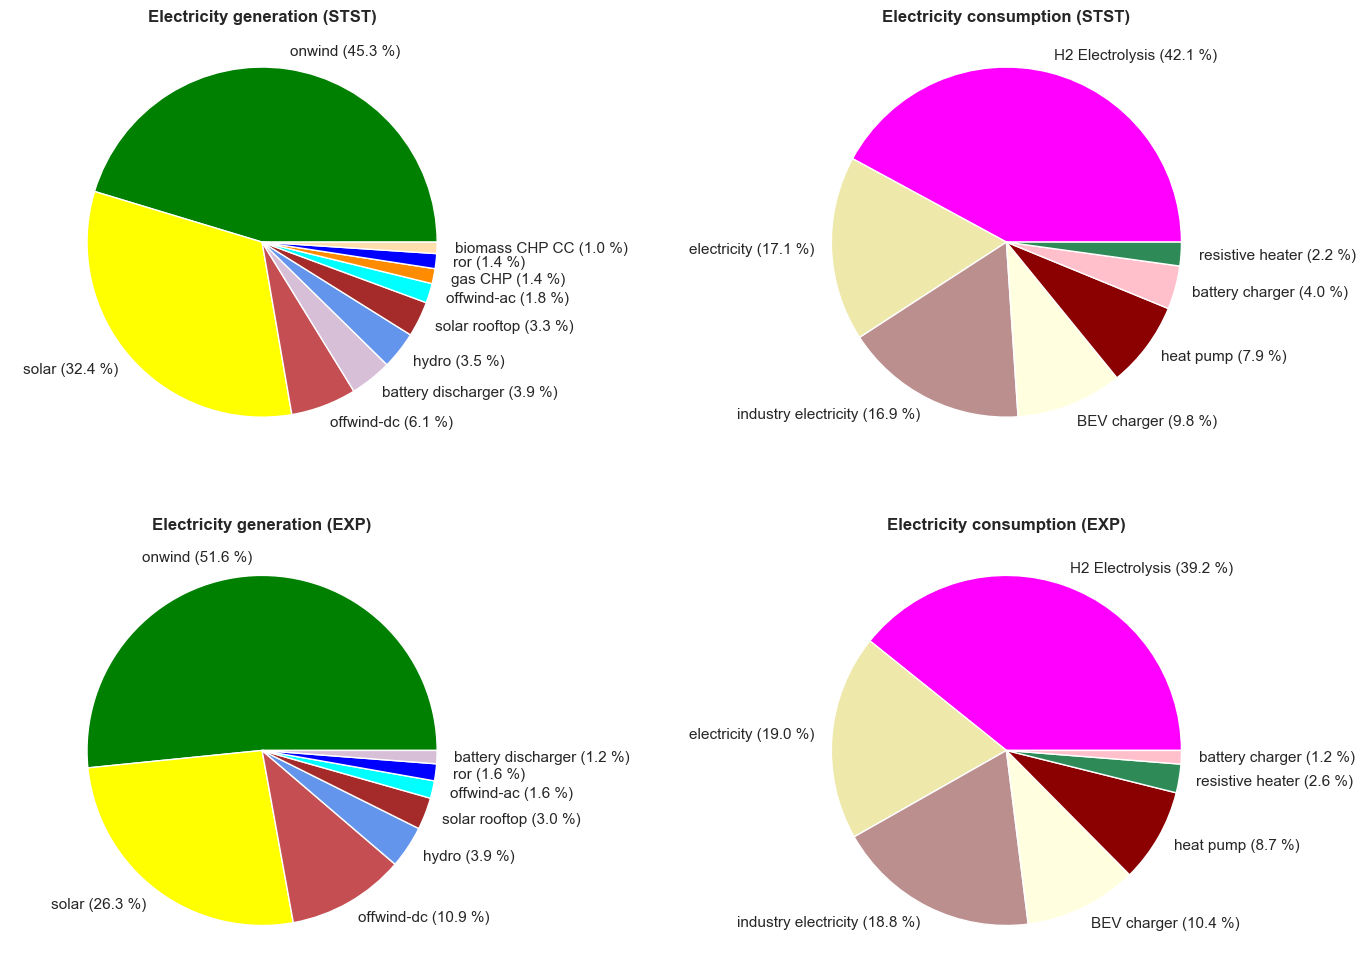

In [42]:
# thesis_plot:

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 11))

for n in [n_no, n_h2]:

    carrier = ["AC", "low voltage"]
    nb = nodal_balance(n, carrier=carrier, time="2013", aggregate=['component', 'bus'], energy=True)
    # convert from MWh to GWh
    nb = nb.unstack(level=[1]) / 1000
    # condense condense_groups
    nb = get_condense_sum(nb, c1_groups, c1_groups_name)
    # rename unhandy column names
    nb.rename(columns=carrier_renaming, inplace=True)

    nb_pos = nb[nb > 0].sum().sort_values(ascending=False)
    # exclude all shares smaller than 1 %
    nb_pos = nb_pos[(nb_pos / nb_pos.sum()) > 0.01]

    nb_neg = abs(nb[nb < 0].sum()).sort_values(ascending=False)
    # exclude all shares smaller than 1 %
    nb_neg = nb_neg[(nb_neg / nb_neg.sum()) > 0.01]

    if n==n_no:
        ax_gen=axs[0, 0]
        ax_con=axs[0, 1]
        title_gen=f"Electricity generation (STST)"
        title_con=f"Electricity consumption (STST)"

    elif n==n_h2:
        ax_gen=axs[1, 0]
        ax_con=axs[1, 1]
        title_gen=f"Electricity generation (EXP)"
        title_con=f"Electricity consumption (EXP)"

    # generation
    c = [carrier_colors[col] for col in nb_pos.index]
    percents = nb_pos.to_numpy() * 100 / nb_pos.to_numpy().sum()
    labels = ['%s (%1.1f %%)' % (l, s) for l, s in zip(nb_pos.index, percents)]

    patches, texts = ax_gen.pie(nb_pos, colors=c, startangle=0, labels=labels)
    ax_gen.axis('equal')
    ax_gen.set_title(title_gen, pad=20, fontweight="bold")

    # consumption
    c = [carrier_colors[col] for col in nb_neg.index]
    percents = nb_neg.to_numpy() * 100 / nb_neg.to_numpy().sum()
    labels = ['%s (%1.1f %%)' % (l, s) for l, s in zip(nb_neg.index, percents)]

    patches, texts = ax_con.pie(nb_neg, colors=c, startangle=0, labels=labels)
    ax_con.axis('equal')

    ax_con.set_title(title_con, pad=20, fontweight="bold")

fig.tight_layout(pad=5)
plt.show()

#fig.savefig(f"{PLOT_DIR}01_general/4.1_system_overview/gen_con_ac_lowvoltage.png")

In [43]:
nb[nb > 0].sum().sort_values(ascending=False) / nb[nb > 0].sum().sort_values(ascending=False).sum()

carrier
onwind                     5.009985e-01
solar                      2.550983e-01
offwind-dc                 1.056276e-01
hydro                      3.796203e-02
solar rooftop              2.870071e-02
offwind-ac                 1.571693e-02
ror                        1.519589e-02
battery discharger         1.183410e-02
biomass CHP CC             8.835447e-03
V2G                        7.038491e-03
gas CHP                    5.167822e-03
PHS                        4.546736e-03
biomass CHP                2.954125e-03
OCGT                       3.224470e-04
home battery discharger    8.476906e-07
DC                         3.265006e-09
AC                         6.202144e-11
BEV charger                0.000000e+00
industry electricity       0.000000e+00
home battery charger       0.000000e+00
electricity                0.000000e+00
battery charger            0.000000e+00
agriculture electricity    0.000000e+00
H2 Electrolysis            0.000000e+00
resistive heater           0.000

In [44]:
# overall electricity generation in TWh

carrier = ["AC", "low voltage"]
nb = nodal_balance(n_h2, carrier=carrier, time="2013", aggregate=['component', 'bus'], energy=True)
# convert from MWh to GWh
nb = nb.unstack(level=[1]) / 1000
# condense condense_groups
nb = get_condense_sum(nb, c1_groups, c1_groups_name)
# rename unhandy column names
nb.rename(columns=carrier_renaming, inplace=True)
# calc sum and convert to TWh
nb[nb > 0].sum().sum() / 1000

# STST: 10202
# EXP: 9172

9172.224918413924

In [45]:
# overall generation and share of all wind and solar technologies:
# wind:  STST: 5347 TWh, 52 % ; EXP: 5708 TWh, 62 %
# solar: STST: 3584 TWh, 35 %; EXP: 2603 TWh, 28 %
# Together: STST: 8931 TWh, 88 % ; EXP: 8311 TWh, 91 \%
# (nb[nb > 0].sum()[["solar", "solar rooftop"]].sum() / 1000 ) / (nb[nb > 0].sum().sum() / 1000)
(nb[nb > 0].sum()[["onwind", "offwind-ac", "offwind-dc", "solar", "solar rooftop"]].sum() / 1000 ) #/ (nb[nb > 0].sum().sum() / 1000)


8311.338773259062

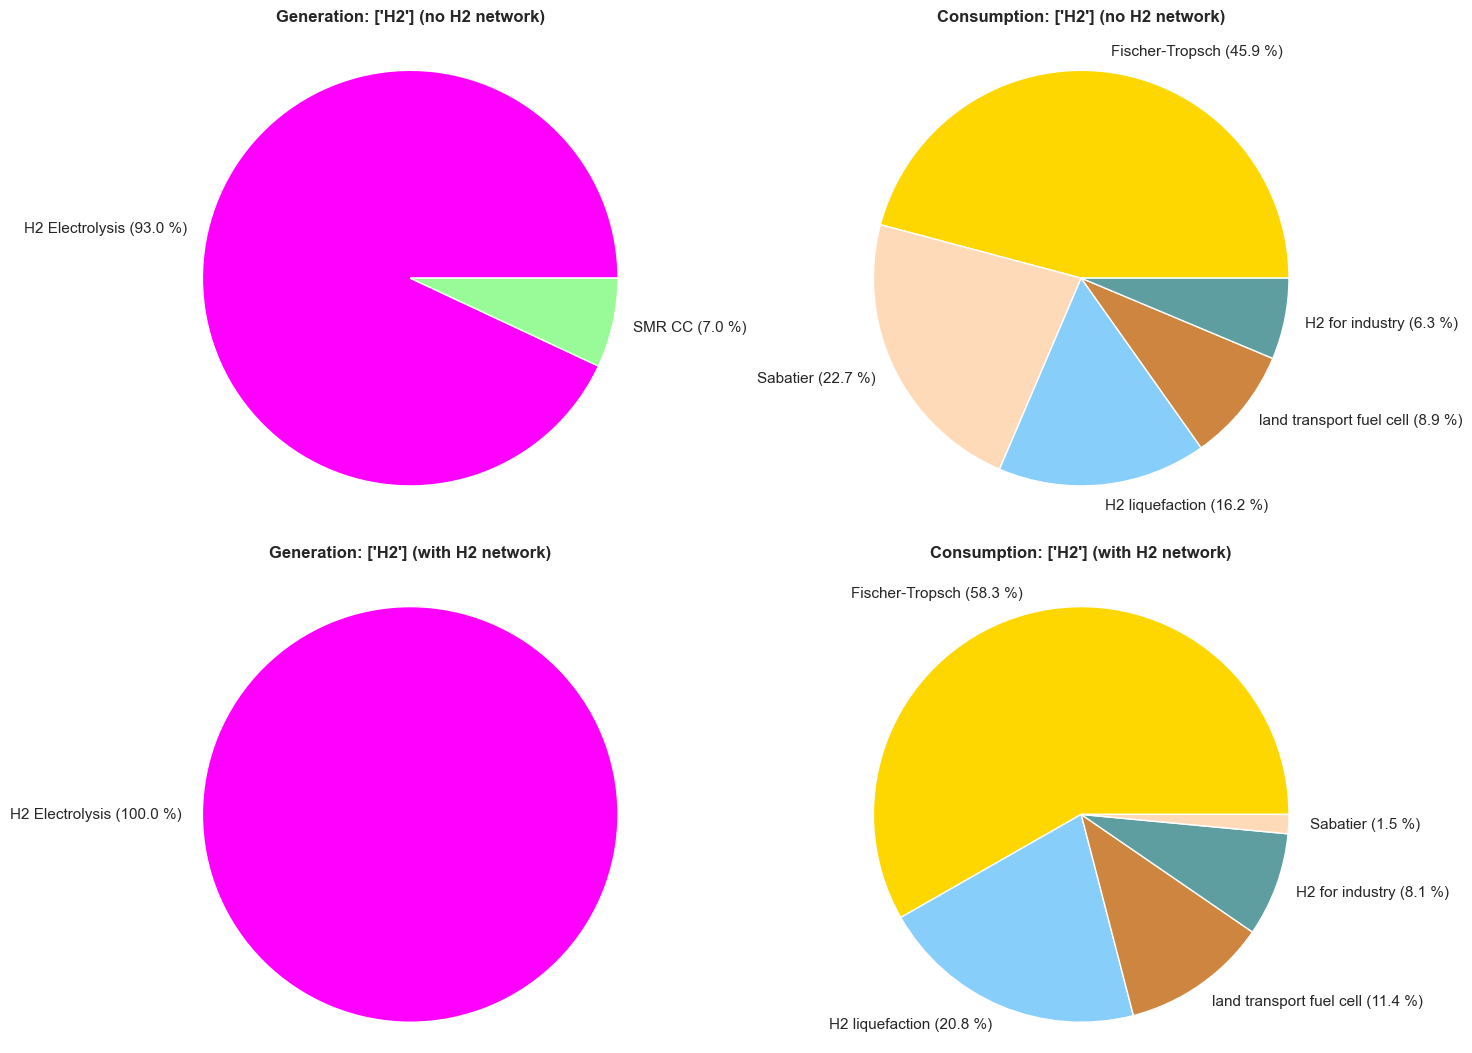

In [46]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 11))

for n in [n_no, n_h2]:

    carrier = ["H2"]
    nb = nodal_balance(n, carrier=carrier, time="2013", aggregate=['component', 'bus'], energy=True)
    # convert from MW to GW
    nb = nb.unstack(level=[1]) / 1000

    nb_pos = nb.sum()[nb.sum() > 0].sort_values(ascending=False)
    # exclude all shares smaller than 1 %
    nb_pos = nb_pos[(nb_pos / nb_pos.sum()) > 0.01]

    nb_neg = abs(nb.sum()[nb.sum() < 0]).sort_values(ascending=False)
    # exclude all shares smaller than 1 %
    nb_neg = nb_neg[(nb_neg / nb_neg.sum()) > 0.01]

    if n==n_no:
        ax_gen=axs[0, 0]
        ax_con=axs[0, 1]
        title_gen=f"Generation: {carrier} (no H2 network)"
        title_con=f"Consumption: {carrier} (no H2 network)"

    elif n==n_h2:
        ax_gen=axs[1, 0]
        ax_con=axs[1, 1]
        title_gen=f"Generation: {carrier} (with H2 network)"
        title_con=f"Consumption: {carrier} (with H2 network)"

    # generation
    c = [carrier_colors[col] for col in nb_pos.index]
    percents = nb_pos.to_numpy() * 100 / nb_pos.to_numpy().sum()
    labels = ['%s (%1.1f %%)' % (l, s) for l, s in zip(nb_pos.index, percents)]

    patches, texts = ax_gen.pie(nb_pos, colors=c, startangle=0, labels=labels)
    ax_gen.axis('equal')
    ax_gen.set_title(title_gen, pad=20, fontweight="bold")

    # consumption
    c = [carrier_colors[col] for col in nb_neg.index]
    percents = nb_neg.to_numpy() * 100 / nb_neg.to_numpy().sum()
    labels = ['%s (%1.1f %%)' % (l, s) for l, s in zip(nb_neg.index, percents)]

    patches, texts = ax_con.pie(nb_neg, colors=c, startangle=0, labels=labels)
    ax_con.axis('equal')

    ax_con.set_title(title_con, pad=20, fontweight="bold")

fig.tight_layout(pad=2)
plt.show()

# fig.savefig(f"{PLOT_DIR}01_general/5.1_hydrogen_overview/gen_con_h2.png")

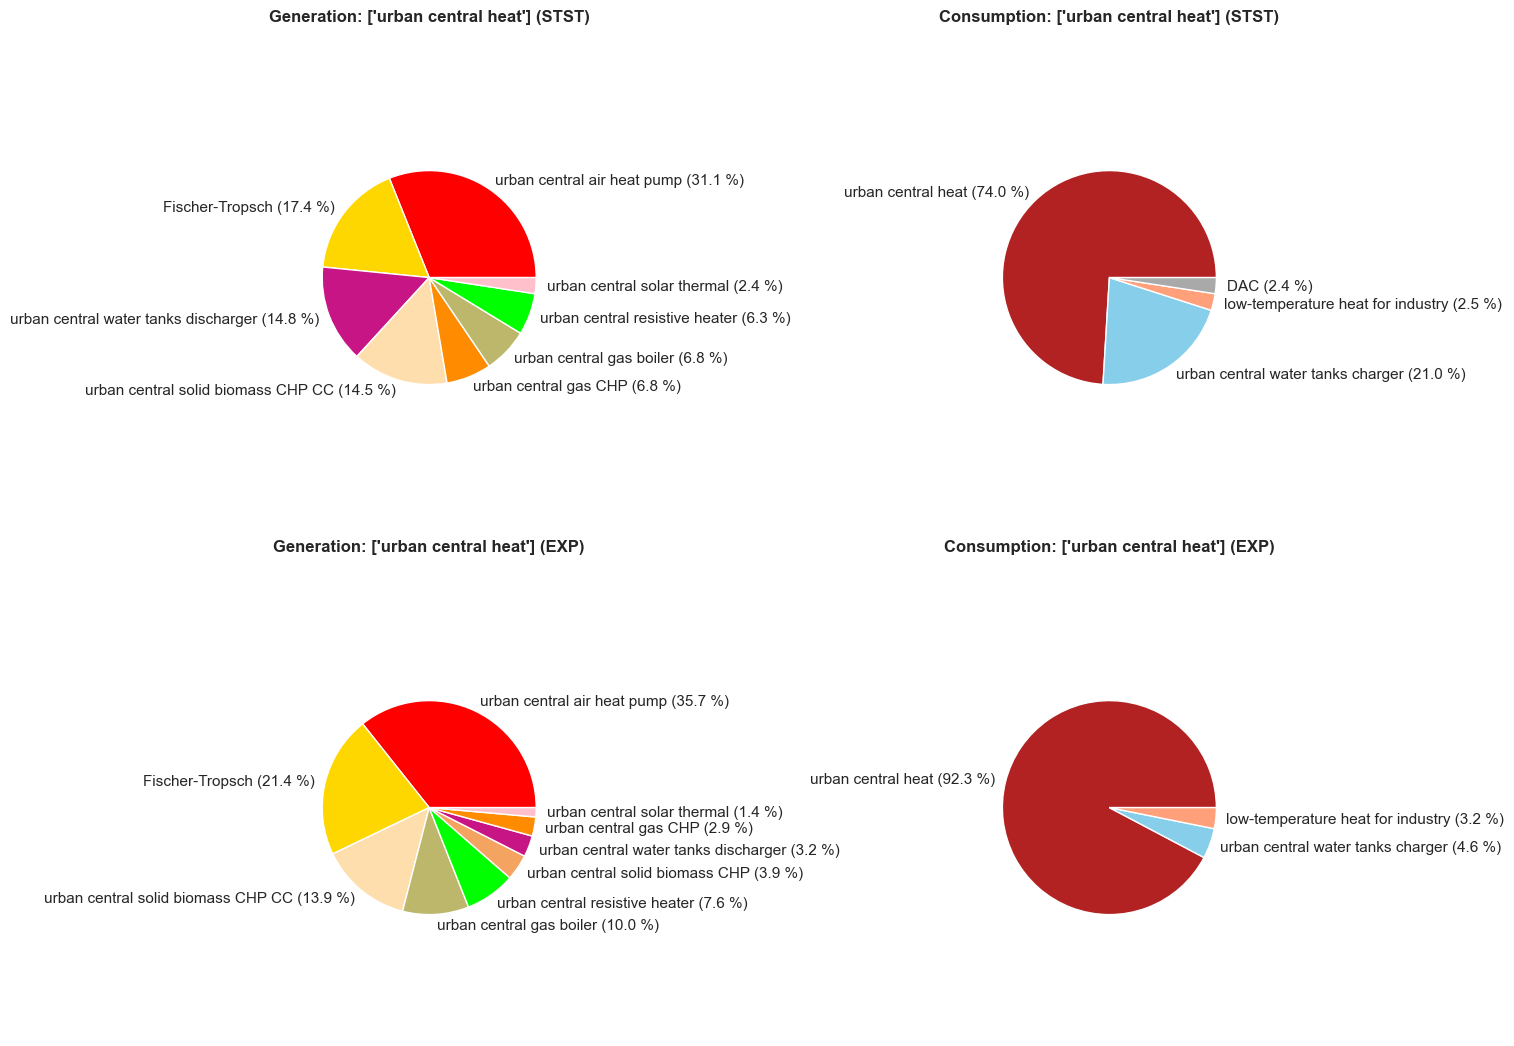

In [47]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 11))

for n in [n_no, n_h2]:

    carrier = ["urban central heat"]
    nb = nodal_balance(n, carrier=carrier, time="2013", aggregate=['component', 'bus'], energy=True)
    # convert from MW to GW
    nb = nb.unstack(level=[1]) / 1000

    nb_pos = nb.sum()[nb.sum() > 0].sort_values(ascending=False)
    # exclude all shares smaller than 1 %
    nb_pos = nb_pos[(nb_pos / nb_pos.sum()) > 0.01]

    nb_neg = abs(nb.sum()[nb.sum() < 0]).sort_values(ascending=False)
    # exclude all shares smaller than 1 %
    nb_neg = nb_neg[(nb_neg / nb_neg.sum()) > 0.01]

    if n==n_no:
        ax_gen=axs[0, 0]
        ax_con=axs[0, 1]
        title_gen=f"Generation: {carrier} (STST)"
        title_con=f"Consumption: {carrier} (STST)"

    elif n==n_h2:
        ax_gen=axs[1, 0]
        ax_con=axs[1, 1]
        title_gen=f"Generation: {carrier} (EXP)"
        title_con=f"Consumption: {carrier} (EXP)"

    # generation
    c = [carrier_colors[col] for col in nb_pos.index]
    percents = nb_pos.to_numpy() * 100 / nb_pos.to_numpy().sum()
    labels = ['%s (%1.1f %%)' % (l, s) for l, s in zip(nb_pos.index, percents)]

    patches, texts = ax_gen.pie(nb_pos, colors=c, startangle=0, labels=labels)
    ax_gen.axis('equal')
    ax_gen.set_title(title_gen, pad=20, fontweight="bold")

    # consumption
    c = [carrier_colors[col] for col in nb_neg.index]
    percents = nb_neg.to_numpy() * 100 / nb_neg.to_numpy().sum()
    labels = ['%s (%1.1f %%)' % (l, s) for l, s in zip(nb_neg.index, percents)]

    patches, texts = ax_con.pie(nb_neg, colors=c, startangle=0, labels=labels)
    ax_con.axis('equal')

    ax_con.set_title(title_con, pad=20, fontweight="bold")

fig.tight_layout(pad=2)
plt.show()

# Fischer Tropsch nebenprdukt Heat

#### Correlation of Capacity

In [48]:
cap_no.corr()["PHS"].sort_values(ascending=False)

PHS                              1.000000
ror                              0.629082
solar thermal                    0.336570
offwind-dc                       0.278613
hydro                            0.176980
solar                            0.167541
biomass CHP                      0.129354
battery charger                  0.096225
battery discharger               0.096225
solar rooftop                    0.080765
SMR CC                           0.033100
biomass CHP CC                   0.022897
V2G                             -0.049420
BEV charger                     -0.049420
gas CHP CC                      -0.056248
H2 liquefaction                 -0.057451
water tanks charger             -0.058320
H2 Electrolysis                 -0.062228
water tanks discharger          -0.124939
onwind                          -0.138759
SMR                             -0.156337
gas boiler                      -0.163852
OCGT                            -0.167675
DC                              -0

In [49]:
cap_h2.corr()["H2 pipeline retrofitted"].sort_values(ascending=False)

H2 pipeline retrofitted          1.000000
gas CHP                          0.165576
offwind-dc                       0.137909
heat pump                        0.090337
gas CHP CC                       0.082084
electricity distribution grid    0.081157
gas boiler                       0.067722
resistive heater                 0.050328
onwind                           0.044667
H2 Fuel Cell                     0.044022
BEV charger                      0.041010
V2G                              0.041010
H2 Electrolysis                  0.040551
battery discharger               0.030149
battery charger                  0.030149
H2 pipeline                      0.014772
SMR                             -0.002298
H2 liquefaction                 -0.003621
offwind-ac                      -0.008828
water tanks discharger          -0.036245
OCGT                            -0.036723
water tanks charger             -0.042427
biomass CHP                     -0.062418
solar thermal                   -0

In [50]:
# check correlation of capacities to check at which locations similar technologies are present
fig = plt.figure(figsize=(28, 14))
sns.heatmap(cap_no.corr()[(abs(cap_no.corr()) > 0.1) & (abs(cap_no.corr()) < 0.8)], annot=True)
plt.close()
plt.show()
# fig.savefig(f"{PLOT_DIR}01_general/4.1_system_overview/no_h2_capa_corr.png")

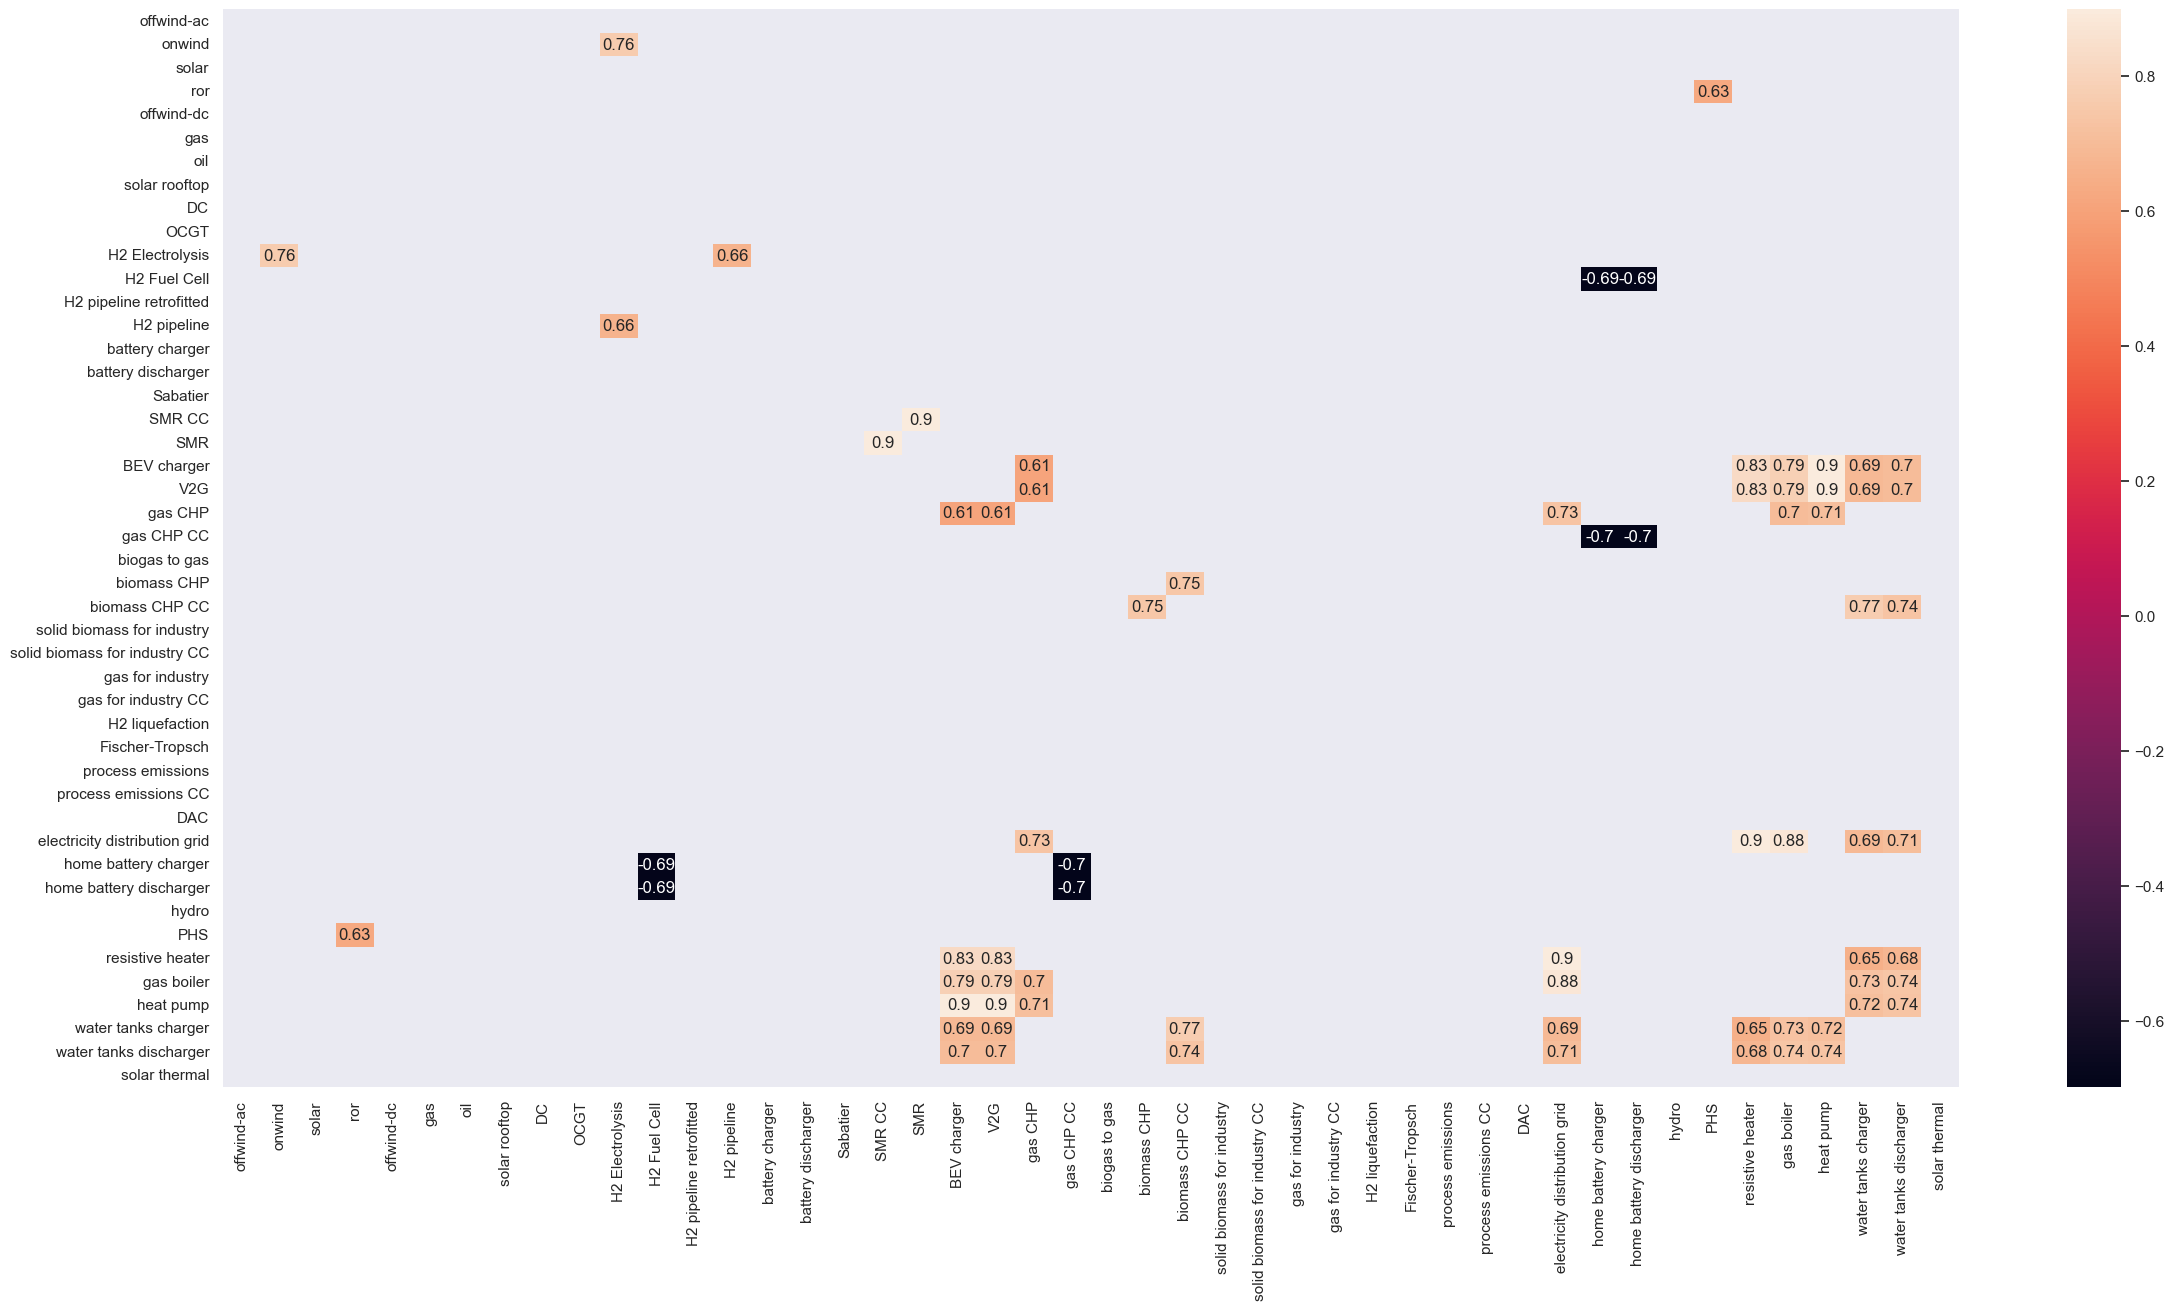

In [51]:
# check correlation of capacities to check at which location similar technologies are present
fig = plt.figure(figsize=(28, 14))
sns.heatmap(cap_h2.corr()[(abs(cap_h2.corr()) > 0.6) & (abs(cap_h2.corr()) < 0.9)], annot=True)
plt.show()
# fig.savefig(f"{PLOT_DIR}01_general/4.1_system_overview/h2_capa_corr.png")

In [52]:
fig = plt.figure(figsize=(28, 14))
diff_cap = cap_no.corr() - cap_h2.corr()
sns.heatmap(diff_cap[(abs(diff_cap) > 0.4) & (abs(diff_cap) < 0.5)], annot=True)
plt.close()
plt.show()
# fig.savefig(f"{PLOT_DIR}01_general/4.1_system_overview/capa_corr_diff_no_minus_h2.png")

Findings: correlation of capacities amogn the scenarios

Interesting and making sense:
- H2 Electrolysis and onwind: (no: 0.67; h2: 0.76) -> onshore wind dominantly used for hydrogen production
- H2 Electrolysis and solar: (no: 0.32; h2: 0.37) -> solar wind partly used for hydrogen production
- H2 Electrolysis and H2 pipeline: 0.66 -> hydrogen production at locations with pipelines
- onwind and h2 pipeline. 0.57 -> onwind used for hydrogen production close to h2 pipelines; pipelines are build where a lot of onwind is located
- offwind-dc and H2 liquefaction: 0.61 ; 0.35 -> offshore wind used to produced liquefied hydrogen (more present in STST scenario as there is less possibility to transport away the offshore wind power generation)

- solar and battery charger: (no: 0.59; h2: 0.54) -> solar used for utility scale battery charging
- BEV and solar rooftop: (STST: 0.63 ; EXP: 0.56) -> solar used to charge vehicles
- BEV and solar: (STST: 0.53 ; EXP: 0.22) -> solar used to charge vehicles

- gas CHP and heat pump / gas boilder / resistive heater : (no: 0.83, 0.72, 0.72 ; h2: 0.71 , 0.7, 0.58) -> all heat sources are at the same location
- gas CHP and biomass CHP / biomas CHP CC: 0.67 / 0.67 ; 0.44 / 0.3 -> all heat sources are at the same location
- gas CHP and water tanks charger: 0.66 ; 0.53 -> heat used for charging thermal storage
- water tanks charger and heat pump / gas boiler / resisitive heater: 0.68 / 0.65 / 0.67 ; 0.73/ 0.72 / 0.65 -> heat used for charging thermal storage

Not making sense or not interesting?:
- biomas CHP and water tanks charger / discharger; (no: 0.007/ 0.048 ; h2: 0.59, 0.55) -> Why no correlation in STST case?
- biomass CHP and home battery charger: -0.52 ; -0.23
- gas CHP CC and home battery charger: -0.65 ; -0.7
- H2 Electrolysis and water tanks charger / water tanks discharger: ( no: 0.39 / 0.44 ; -0.12 / < abs(0.1)) -> rather random?

Not interesting and making sense:
- solar and solar rooftop (0.5 ; 0.47)
- solar thermal and solar: 0.56 ; 0.41

Not interesting and not making sense:
- H2 Fuel cell and home battery charger / home battery discharger: (no: -0.032; h2: -0.69) not very relevant as there is almost no capacity of fuel cell
- SMR CC and H2 liquefaction: (no: 0.72; h2: -0.16) strong correlation with SMR CC and H2 liquefaction in STST scenario; small correlation in EXP scenario random due to little capacity of SMR CC
- H2 Fuel Cell and biomass CHP / biomass CHP CC: (no: 0.032 / <0.01 ; ) H2 Fuel Cell has no relevance

#### Capacity Coverage (%)
- calc capacities in percentage
- calc the min(capA, capB) for every location to see how many percentage points are present at a location from both technologies. If it is 100, the distributio of capacity is the same, if it is 0, there is no capacity present of technology A at the same location where capacity of technology B is present.
- measure the similarity of the distribution
how to calc that?

In [53]:
# Note: gas, oil, sabatier, biogas to gas, ... only have capacity at EU bus

cap_no_perc = pd.DataFrame(cap_no.fillna(0) / cap_no.fillna(0).sum())
cap_h2_perc = pd.DataFrame(cap_h2.fillna(0) / cap_h2.fillna(0).sum())

# exclude all carriers that only have capacity at EU bus
cap_no_perc = cap_no_perc[cap_no_perc.columns[cap_no_perc.loc["EU"]!=1]]
cap_h2_perc = cap_h2_perc[cap_h2_perc.columns[cap_h2_perc.loc["EU"]!=1]]

# drop EU row
cap_no_perc.drop("EU", inplace=True)
cap_h2_perc.drop("EU", inplace=True)

cap_no_cc = pd.DataFrame(index=cap_no_perc.columns, columns=cap_no_perc.columns)
cap_h2_cc = pd.DataFrame(index=cap_h2_perc.columns, columns=cap_h2_perc.columns)

for c1 in cap_no_cc.columns:
    for c2 in cap_no_cc.index:
        cap_no_cc.loc[c1, c2] = cap_no_perc[[c1, c2]].min(axis=1).sum()

for c1 in cap_h2_cc.columns:
    for c2 in cap_h2_cc.index:
        cap_h2_cc.loc[c1, c2] = cap_h2_perc[[c1, c2]].min(axis=1).sum()

# convert to float
cap_no_cc = cap_no_cc.astype(float)
cap_h2_cc = cap_h2_cc.astype(float)

In [54]:
fig = plt.figure(figsize=(28, 14))
sns.heatmap(cap_no_cc[cap_no_cc >0.8], annot=True)
plt.close()
plt.show()

In [55]:
fig = plt.figure(figsize=(28, 14))
sns.heatmap(cap_h2_cc[cap_h2_cc > 0.8], annot=True)
plt.close()
plt.show()

In [56]:
round(cap_no_cc - cap_h2_cc.loc[cap_no_cc.index, cap_no_cc.columns], 2)

offwind-ac  onwind  solar   ror  offwind-dc  \
offwind-ac                          -0.00    0.02   0.07 -0.00        0.02   
onwind                               0.02   -0.00   0.16  0.04       -0.03   
solar                                0.07    0.16   0.00  0.00        0.07   
ror                                 -0.00    0.04   0.00  0.00       -0.02   
offwind-dc                           0.02   -0.03   0.07 -0.02       -0.00   
solar rooftop                        0.05    0.16   0.10 -0.02        0.03   
DC                                   0.03   -0.11  -0.04 -0.06        0.01   
OCGT                                -0.00    0.18   0.04 -0.06        0.10   
H2 Electrolysis                      0.03    0.00   0.13  0.08       -0.05   
H2 Fuel Cell                        -0.06   -0.34  -0.41 -0.32       -0.14   
battery charger                      0.02    0.10   0.28  0.24        0.03   
battery discharger                   0.02    0.10   0.28  0.24        0.03   
SMR CC                               0.16   -0.12  -0.00 -0.04        0.06   
SMR                                  0.10   -0.23  -0.20 -0.20       -0.05   
BEV charger                          0.02    0.14   0.23  0.00        0.00   
V2G                                  0.02    0.14   0.23  0.00        0.00   
gas CHP                             -0.00    0.12   0.20  0.01       -0.03   
gas CHP CC                          -0.02   -0.00   0.13  0.02       -0.07   
biomass CHP                          0.06    0.34   0.41  0.08        0.11   
biomass CHP CC                      -0.01    0.09   0.15  0.01       -0.01   
H2 liquefaction                      0.01    0.04   0.08  0.00        0.02   
electricity distribution grid        0.03    0.15   0.21 -0.01        0.01   
home battery charger                 0.03    0.14   0.20 -0.00        0.00   
home battery discharger              0.03    0.14   0.20 -0.00        0.00   
hydro                                0.00    0.03   0.00  0.00       -0.00   
PHS                                  0.00    0.04   0.04  0.00       -0.03   
resistive heater                     0.04    0.14   0.20 -0.00        0.01   
gas boiler                           0.02    0.11   0.21  0.00        0.01   
heat pump                            0.03    0.12   0.22 -0.00       -0.00   
water tanks charger                  0.05    0.23   0.21 -0.06        0.05   
water tanks discharger               0.06    0.24   0.21 -0.07        0.06   
solar thermal                        0.00   -0.07  -0.07  0.19       -0.03   

                               solar rooftop    DC  OCGT  H2 Electrolysis  \
offwind-ac                              0.05  0.03 -0.00             0.03   
onwind                                  0.16 -0.11  0.18             0.00   
solar                                   0.10 -0.04  0.04             0.13   
ror                                    -0.02 -0.06 -0.06             0.08   
offwind-dc                              0.03  0.01  0.10            -0.05   
solar rooftop                           0.00 -0.07 -0.02             0.16   
DC                                     -0.07  0.00  0.08            -0.10   
OCGT                                   -0.02  0.08 -0.00             0.18   
H2 Electrolysis                         0.16 -0.10  0.18            -0.00   
H2 Fuel Cell                           -0.48 -0.13 -0.10            -0.24   
battery charger                         0.33 -0.07  0.06             0.10   
battery discharger                      0.33 -0.07  0.06             0.10   
SMR CC                                  0.03 -0.06  0.01            -0.13   
SMR                                    -0.24 -0.10  0.00            -0.18   
BEV charger                             0.13 -0.06  0.02             0.22   
V2G                                     0.13 -0.06  0.02             0.22   
gas CHP                                 0.18 -0.08  0.05             0.17   
gas CHP CC                              0.12 -0.11  0.03             0

In [57]:
fig = plt.figure(figsize=(28, 14))
diff_cc = round(cap_no_cc - cap_h2_cc.loc[cap_no_cc.index, cap_no_cc.columns], 2)
sns.heatmap(diff_cc[abs(diff_cc) > 0.5], annot=True)
plt.close()
plt.show()

### Correlation of generation
- temporal correlation
- spatial correlation

In [58]:
def get_generation(carrier = "onwind", n=n_no, period="2013"):

    if carrier in n.generators.carrier.unique().tolist():
        result = n.generators_t.p.loc[period, n.generators.carrier == carrier]
        result.columns = result.columns.map(n.generators.bus)
        result.columns = result.columns.map(n.buses.location)

    elif carrier in n.links.carrier.unique().tolist():
        result = -n.links_t.p1.loc[period, n.links.carrier == carrier]
        result.columns = result.columns.map(n.links.bus1)
        result = result.groupby(result.columns, axis=1).sum()
        result.columns = result.columns.map(n.buses.location)

    elif carrier in n.storage_units.carrier.unique().tolist():
        result = n.storage_units_t.p_dispatch.loc[period, n.storage_units.carrier == carrier]
        result.columns = result.columns.map(n.storage_units.bus)
        result.columns = result.columns.map(n.buses.location)

    elif carrier in n.loads.carrier.unique().tolist():
        result = n.loads_t.p.loc[period, n.loads.carrier == carrier]
        result.columns = result.columns.map(n.loads.bus)
        result.columns = result.columns.map(n.buses.location)

    else:
        result = None

    return result

In [59]:
# temporal correlation
n = n_no
c1 = "onwind"
c2 = "H2 Electrolysis"

gen1 = get_generation(carrier=c1, n=n_no)
gen2 = get_generation(carrier=c2, n=n_no)

In [60]:
# overall temporal correlation
gen1.sum(axis=1).corr(gen2.sum(axis=1))

0.4471500366843796

In [61]:
# temporal correlation per location

com_cols = gen1.columns.intersection(gen2.columns)
loc_res = pd.DataFrame(index=com_cols, columns=["corr"])

for loc in com_cols:
    loc_res.loc[loc,"corr"] = gen1[loc].corr(gen2[loc])

# mean
loc_res.mean()

# generation weighted mean
(gen1[com_cols].sum() * loc_res.T / gen1[com_cols].sum().sum()).sum().sum()

0.6397827544206894

In [62]:
# overall spatial correlation
gen1.sum(axis=0).corr(gen2.sum(axis=0))

0.8301751906090489

In [63]:
carriers = ["solar", "onwind", "offwind-ac", "ror", "offwind-dc", "H2 Electrolysis", "battery charger",
            "battery discharger", "Sabatier", "SMR CC", "BEV charger", "V2G", "urban central air heat pump",
            "urban central solid biomass CHP", "Fischer-Tropsch", "hydro", "PHS", "electricity", "H2 for industry", "industry electricity", "agriculture electricity", "urban central heat", "land transport fuel cell"]
len(carriers)

23

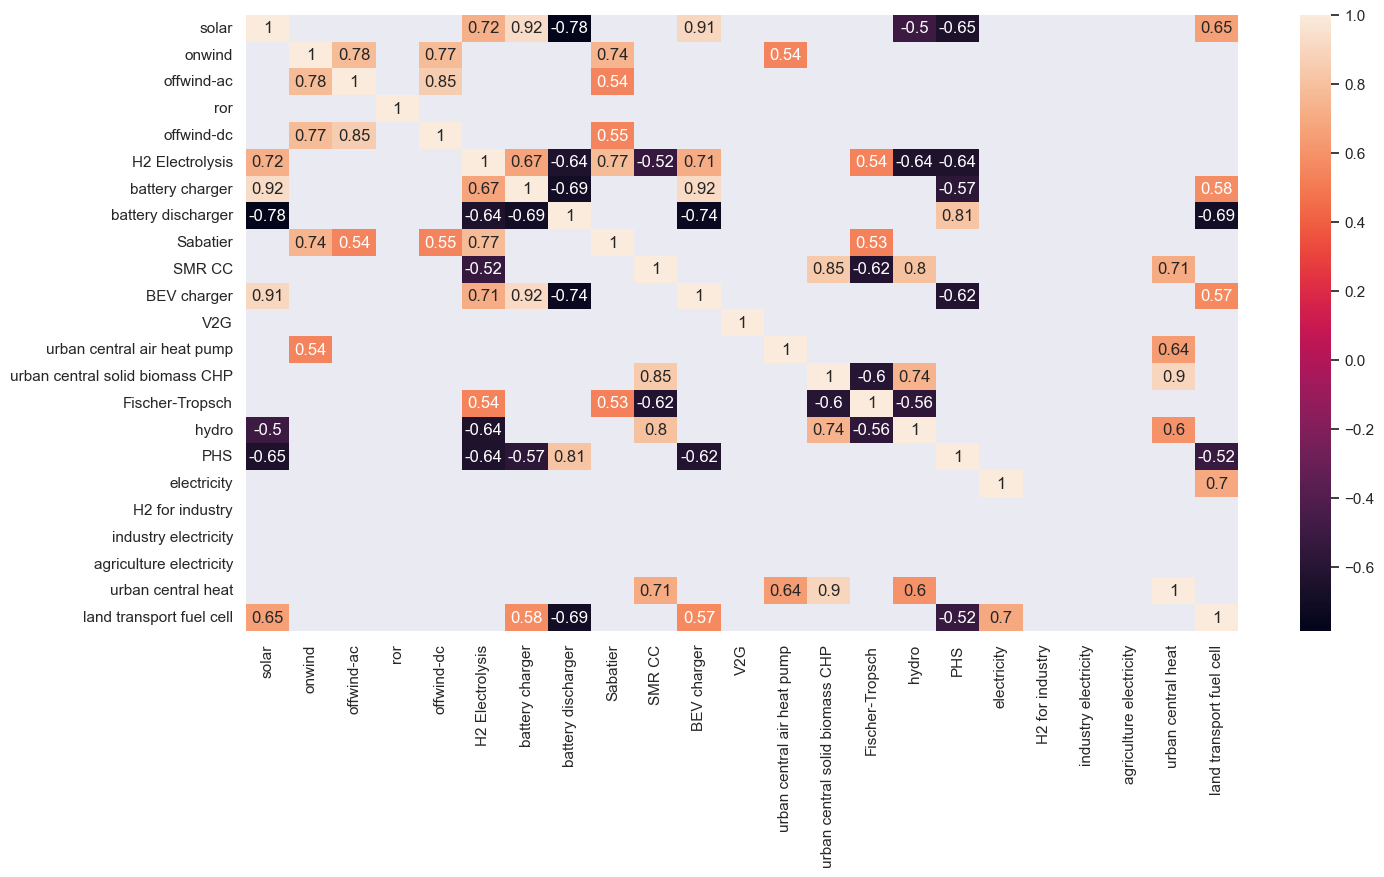

In [64]:
# temporal correlation: aggregated over locations as sum, then taking correlation

n = n_no
res_temp_all_n_no = pd.DataFrame(index=carriers, columns=carriers)

for c1 in carriers:
    for c2 in carriers:
        gen1 = get_generation(carrier=c1, n=n)
        gen2 = get_generation(carrier=c2, n=n)

        # correlation
        res_temp_all_n_no.loc[c1, c2] = gen1.sum(axis=1).corr(gen2.sum(axis=1))

res_temp_all_n_no = res_temp_all_n_no.astype("float")

fig = plt.figure(figsize=(16, 8))
sns.heatmap(res_temp_all_n_no[abs(res_temp_all_n_no) > 0.5], annot=True)
plt.show()

In [65]:
# generation weighted temporal correlation per location

n = n_no
res_temp_n_no = pd.DataFrame(index=carriers, columns=carriers)

for c1 in carriers:
    for c2 in carriers:

        gen1 = get_generation(carrier=c1, n=n)
        gen2 = get_generation(carrier=c2, n=n)

        com_cols = gen1.columns.intersection(gen2.columns)
        loc_res = pd.DataFrame(index=com_cols, columns=["corr"])

        for loc in com_cols:
            loc_res.loc[loc,"corr"] = gen1[loc].corr(gen2[loc])

        # correlation of two vectors with constant values is nan
        loc_res.dropna(inplace=True)

        # generation weighted mean of correlations per location
        res_temp_n_no.loc[c1,c2] = round((gen1[loc_res.index].sum() * loc_res.T / gen1[loc_res.index].sum().sum()).sum().sum(), 2)

res_temp_n_no = res_temp_n_no.astype("float")

In [66]:
res_temp_n_no

solar  onwind  offwind-ac   ror  offwind-dc  \
solar                             1.00   -0.17       -0.17 -0.03       -0.20   
onwind                           -0.20    1.00        0.80 -0.04        0.64   
offwind-ac                       -0.19    0.85        1.00 -0.01        0.94   
ror                               0.03   -0.01        0.02  1.00        0.00   
offwind-dc                       -0.19    0.76        0.87 -0.08        1.00   
H2 Electrolysis                   0.36    0.57        0.48 -0.01        0.46   
battery charger                   0.84   -0.08       -0.10 -0.06       -0.13   
battery discharger               -0.53   -0.11       -0.12  0.04       -0.07   
Sabatier                          0.00    0.00        0.00  0.00        0.00   
SMR CC                           -0.34   -0.23       -0.35 -0.04       -0.42   
BEV charger                       0.64    0.08        0.05 -0.06        0.07   
V2G                              -0.13   -0.10       -0.11  0.01       -0.09   
urban central air heat pump       0.18    0.31        0.29  0.00        0.29   
urban central solid biomass CHP  -0.23   -0.08       -0.01 -0.06       -0.08   
Fischer-Tropsch                   0.00    0.00        0.00  0.00        0.00   
hydro                            -0.23   -0.24       -0.22 -0.02       -0.28   
PHS                              -0.30   -0.11       -0.15 -0.01       -0.16   
electricity                       0.29    0.02        0.02 -0.13        0.03   
H2 for industry                  -0.00    0.00        0.00  0.00       -0.00   
industry electricity             -0.00   -0.00       -0.00 -0.00       -0.00   
agriculture electricity          -0.00    0.00        0.00  0.00       -0.00   
urban central heat               -0.17    0.14        0.17  0.02        0.14   
land transport fuel cell          0.55   -0.03       -0.03 -0.03       -0.04   

                                 H2 Electrolysis  battery charger  \
solar                                       0.72             0.76   
onwind                                      0.64             0.31   
offwind-ac                                  0.58             0.19   
ror                                         0.09            -0.02   
offwind-dc                                  0.64             0.22   
H2 Electrolysis                             1.00             0.56   
battery charger                             0.67             1.00   
battery discharger                         -0.48            -0.45   
Sabatier                                    0.00             0.00   
SMR CC                                     -0.74            -0.23   
BEV charger                                 0.53             0.70   
V2G                                        -0.10            -0.17   
urban central air heat pump                 0.26             0.30   
urban central solid biomass CHP            -0.42            -0.19   
Fischer-Tropsch                             0.00             0.00   
hydro                                      -0.29            -0.31   
PHS                                        -0.30            -0.29   
electricity                                 0.19             0.24   
H2 for industry                             0.00             0.00   
industry electricity                       -0.00            -0.00   
agriculture electricity                     0.00            -0.00   
urban central heat                         -0.21            -0.05   
land transport fuel cell                    0.37             0.41   

                                 battery discharger  Sabatier  SMR CC  ...  \
solar                                         -0.49      0.00   -0.21  ...   
onwind                                         0.08      0.00   -0.34  ...   
offwind-ac                                    -0.05      0.00   -0.32  ...   
ror                                            0.02      0.00   -0.22  ...   
offwind-dc                                    -0.04      0.00   -

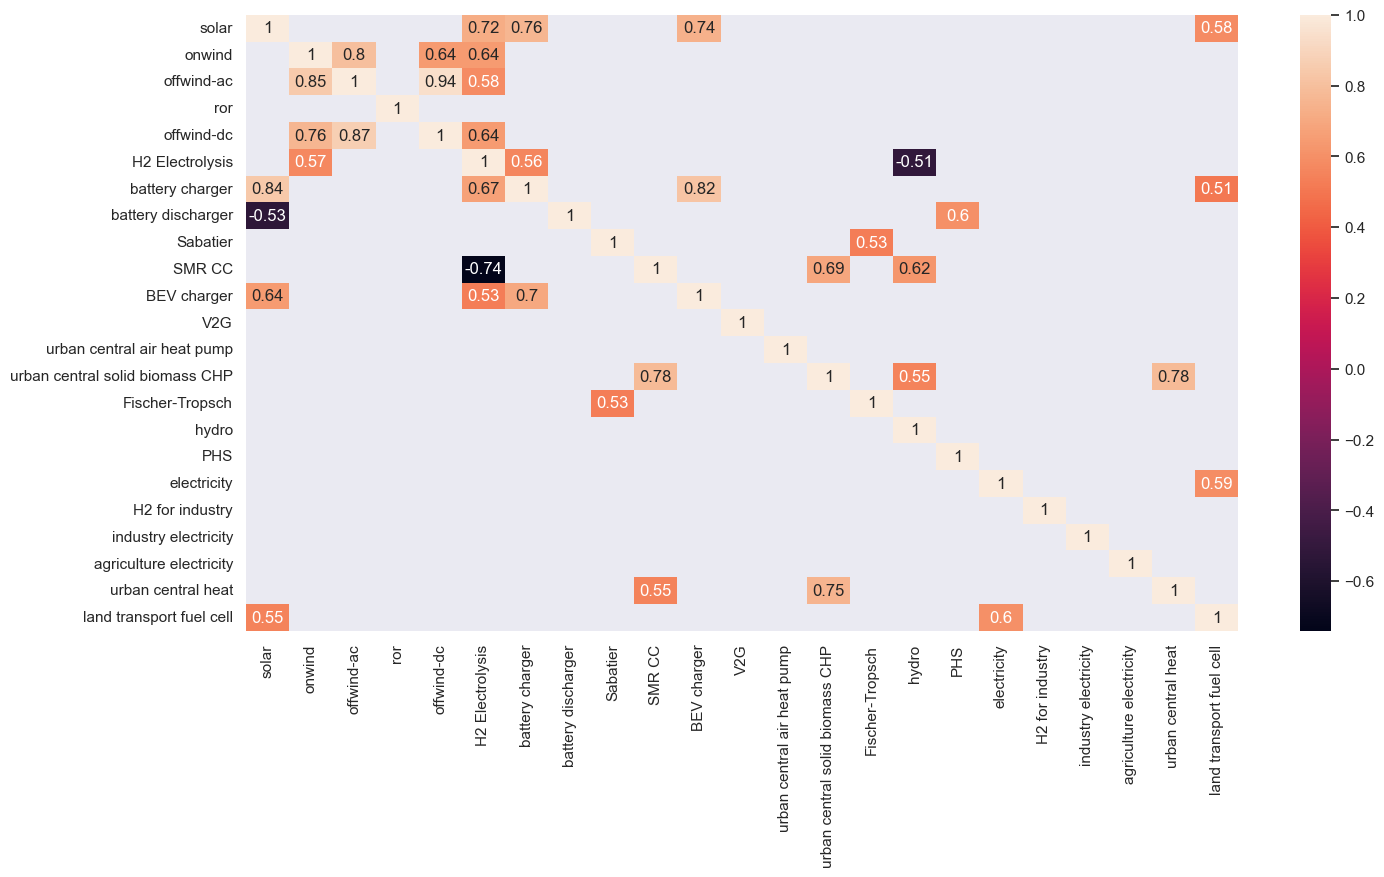

In [67]:
fig = plt.figure(figsize=(16, 8))
sns.heatmap(res_temp_n_no[abs(res_temp_n_no) > 0.5], annot=True)
plt.show()

In [68]:
# overall spatial correlation

n = n_no
res_loc_all_n_no = pd.DataFrame(index=carriers, columns=carriers)

for c1 in carriers:
    for c2 in carriers:

        gen1 = get_generation(carrier=c1, n=n)
        gen2 = get_generation(carrier=c2, n=n)

        # corrrelation
        res_loc_all_n_no.loc[c1,c2] = gen1.sum(axis=0).corr(gen2.sum(axis=0))

res_loc_all_n_no = res_loc_all_n_no.astype("float")

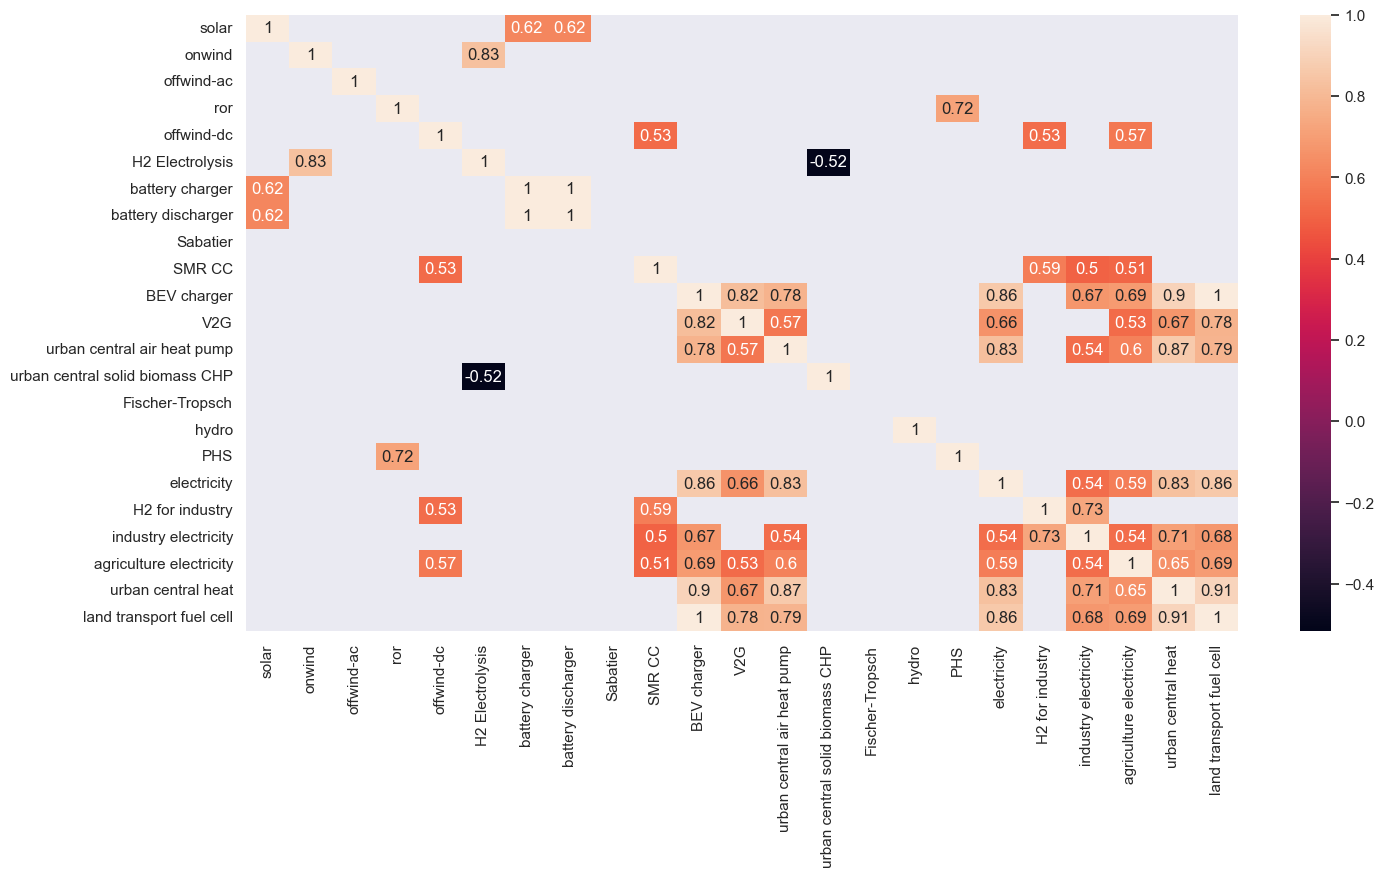

In [69]:
fig = plt.figure(figsize=(16, 8))
sns.heatmap(res_loc_all_n_no[abs(res_loc_all_n_no) > 0.5], annot=True)
plt.show()

## Energy Flow

### Balance map

In [70]:
# plot map with overall balance of hydrogen and electricity per region

![](../../../../Pictures/Screenshots/Screenshot_20230215_101123.png)

In [71]:
# carrier of buses are the same for the networks
n_h2.buses.carrier.unique().tolist() == n_no.buses.carrier.unique().tolist()

True

In [72]:
n_h2.buses.carrier.unique().tolist()

['AC',
 'co2',
 'co2 stored',
 'gas',
 'H2',
 'battery',
 'Li ion',
 'residential rural heat',
 'residential rural water tanks',
 'services rural heat',
 'services rural water tanks',
 'residential urban decentral heat',
 'residential urban decentral water tanks',
 'services urban decentral heat',
 'services urban decentral water tanks',
 'urban central heat',
 'urban central water tanks',
 'biogas',
 'solid biomass',
 'solid biomass for industry',
 'gas for industry',
 'H2 liquid',
 'oil',
 'process emissions',
 'low voltage',
 'home battery']

In [73]:
test = nodal_balance(n_no, carrier=["AC", "low voltage", "H2", "gas", "oil"], aggregate=["component", "snapshot", "carrier"], time="2013", energy=True)

In [74]:
test

bus
AL0 0    334.665219
AT0 0    348.853042
AT0 1    234.938628
AT0 2    493.143961
BA0 0    662.318399
            ...    
SE3 5    -87.487738
SE3 6    458.948440
SE3 7   -399.465162
SI0 0    324.601860
SK0 0    409.438425
Length: 182, dtype: float64

In [75]:
test2 = nodal_balance(n_no, carrier=["AC", "low voltage"],aggregate=["component", "snapshot", "carrier"], time="2013", energy=True)
test2

bus
AL0 0    333.340198
AT0 0     24.109425
AT0 1     29.777586
AT0 2     59.505479
BA0 0    262.371388
            ...    
SE3 5   -174.010336
SE3 6   -188.713297
SE3 7   -427.935814
SI0 0     49.241415
SK0 0     80.663653
Length: 181, dtype: float64

In [76]:
test.groupby(["bus"]).sum()

bus
AL0 0    334.665219
AT0 0    348.853042
AT0 1    234.938628
AT0 2    493.143961
BA0 0    662.318399
            ...    
SE3 5    -87.487738
SE3 6    458.948440
SE3 7   -399.465162
SI0 0    324.601860
SK0 0    409.438425
Length: 182, dtype: float64

In [77]:
# oil, gas, co2 is only at EU level
carrier_sets = [["AC", "low voltage"], ["H2"], ["urban central heat"], ["AC", "low voltage", "H2"]]

for carrier_set in carrier_sets:
    # nodal balance in MWh
    df_no_ons[f"{carrier_set}_nb"] = nodal_balance(n_no, carrier=carrier_set, time="2013", aggregate=["component", "snapshot", "carrier"], energy=True)
    df_h2_ons[f"{carrier_set}_nb"] = nodal_balance(n_h2, carrier=carrier_set, time="2013", aggregate=["component", "snapshot", "carrier"], energy=True)

df_no_ons.iloc[: , -10:].head()

gas for industry_lmp  H2 liquid_lmp    oil_lmp  process emissions_lmp  \
name                                                                           
AL0 0            113.135704     137.617875  50.009981            -408.520212   
AT0 0            113.135704     151.448316  50.009981            -408.520212   
AT0 1            113.135704     154.026970  50.009981            -408.520212   
AT0 2            113.135704     148.663198  50.009981            -408.520212   
BA0 0            113.135704     147.689672  50.009981            -408.520212   

       low voltage_lmp  home battery_lmp  ['AC', 'low voltage']_nb  \
name                                                                 
AL0 0       100.338046        100.380697                333.340198   
AT0 0       115.006246        115.044440                 24.109425   
AT0 1       121.910720        121.947576                 29.777586   
AT0 2       112.352878        112.386673                 59.505479   
BA0 0       112.040690        112.006725                262.371388   

        ['H2']_nb  ['urban central heat']_nb  ['AC', 'low voltage', 'H2']_nb  
name                                                                          
AL0 0  -43.228095                -400.425714                      334.665219  
AT0 0  299.487554                -740.105514                      348.853042  
AT0 1  173.612894                -657.313962                      234.938628  
AT0 2  388.881199                -602.902843                      493.143961  
BA0 0  368.229008                -551.922756                      662.318399

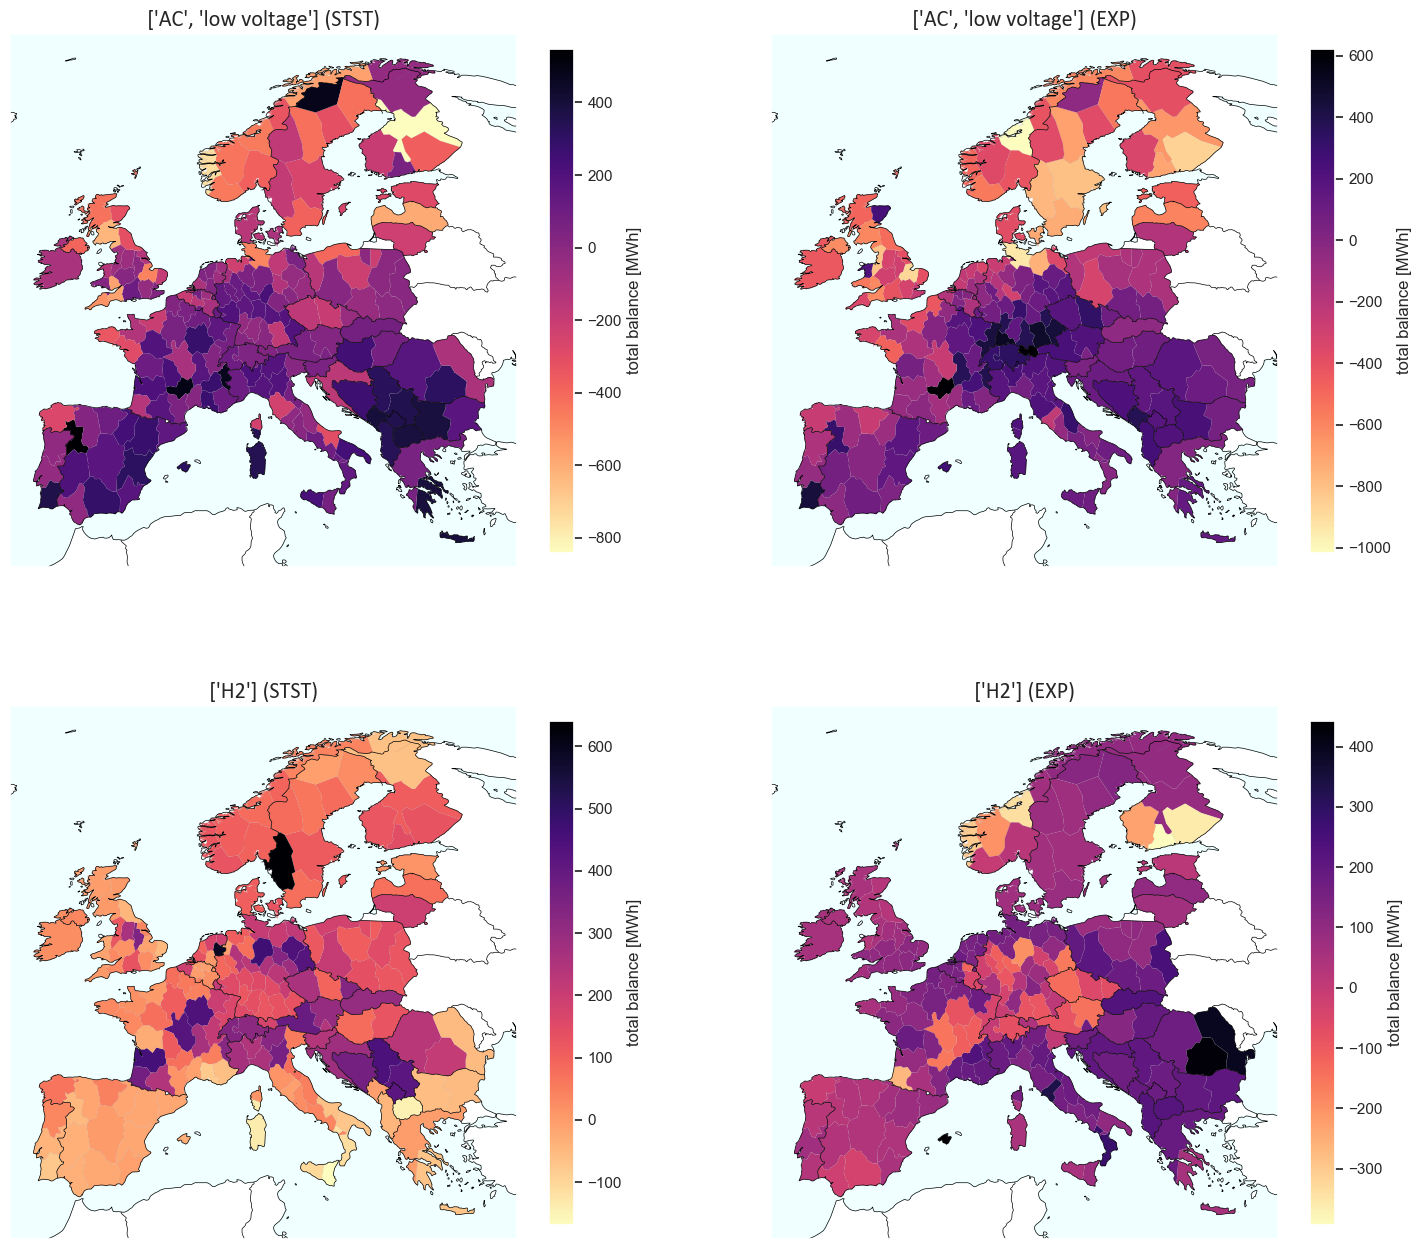

In [78]:
# nodal balance electricity and hydrogen
carrier_sets_plot = [["AC", "low voltage"], ["AC", "low voltage"], ["H2"], ["H2"]]

fig, axs = plt.subplots(ncols=2, nrows=2, subplot_kw={'projection': ccrs.EqualEarth()},
                        figsize=(18, 16))
crs = ccrs.EqualEarth()

for i, ax in enumerate(axs.reshape(-1)):

    if i in [0,2]:
        df = df_no_ons
        title = "(STST)"
    elif i in [1,3]:
        df = df_h2_ons
        title = "(EXP)"

    ax.add_feature(cartopy.feature.BORDERS, edgecolor='black', linewidth=0.5)
    ax.coastlines(edgecolor='black', linewidth=0.5)
    ax.set_facecolor('white')
    ax.add_feature(cartopy.feature.OCEAN, color='azure')

    df.to_crs(crs.proj4_init).plot(column=f"{carrier_sets_plot[i]}_nb",
                                                   ax=ax,
                                                   cmap=plt.get_cmap("magma_r"),
                                                   linewidth=0.05,
                                                   edgecolor = 'grey',
                                                   legend=True,
                                                   legend_kwds={'label':"total balance [MWh]",
                            'orientation': "vertical",
                                      'shrink' : 0.9})

    ax.set_title(f"{carrier_sets_plot[i]} {title}", fontsize=16, **font1)
plt.show()

In [79]:
# Figure 6 in Neumann paper
carrier = ["AC", "low voltage", "H2", "gas", "oil"]
nb = nodal_balance(n_h2, carrier=n_h2.buses.carrier.unique().tolist(), time="2013", aggregate=["component", "snapshot", "carrier"], energy=True)

In [80]:
nb.describe()

count     182.000000
mean      355.205699
std       322.542205
min      -544.109260
25%       127.913871
50%       411.690449
75%       618.112881
max      1025.215984
dtype: float64

### Balance Flow

![](../../../../Pictures/Screenshots/Screenshot_20230215_101816.png)

In [81]:
n_no.lines_t.p0.sum()

Line
1     -1.187061e+06
10     8.523414e+06
100    4.419293e+06
101    9.065389e+05
102   -1.000031e+06
           ...     
95     9.479547e+05
96    -8.982532e+04
97     1.619466e+05
98     8.198081e+05
99    -1.042867e+06
Length: 323, dtype: float64

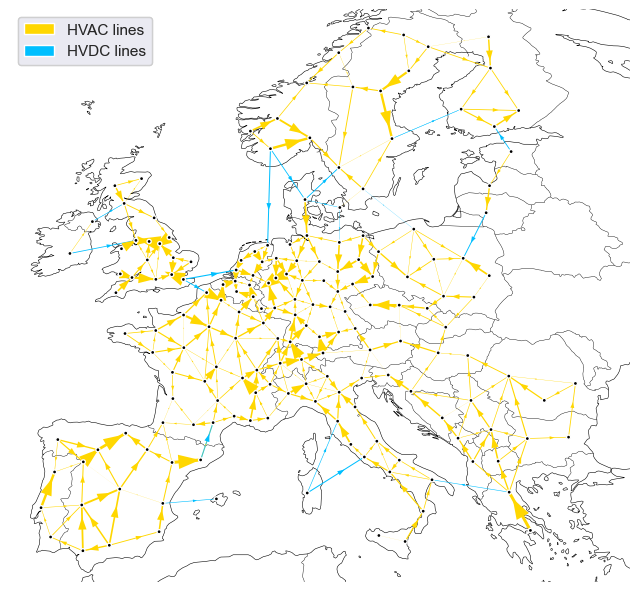

In [82]:
# Electricity network

fig, ax = plt.subplots(1, 1, subplot_kw={"projection": ccrs.EqualEarth()}, figsize=(8, 8))

m_no.plot(ax=ax, projection=ccrs.EqualEarth(), bus_colors="black", line_colors="gold", link_colors="deepskyblue",
          line_widths=5e-4, link_widths=1e-3, flow="sum")
pypsa.plot.add_legend_patches(ax=ax, labels=["HVAC lines", "HVDC lines"], colors=["gold","deepskyblue"], legend_kw={'loc': 'upper left'})
plt.show()

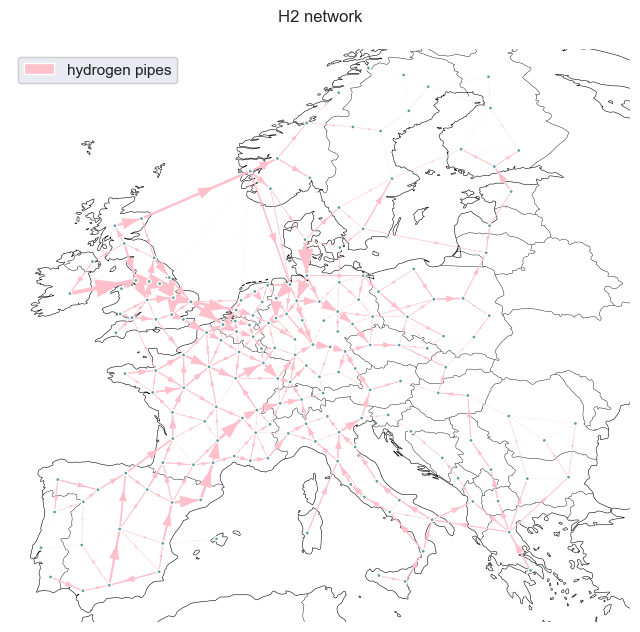

In [83]:
# Hydrogen network
# link_cmap=plt.get_cmap("magma_r")

fig, ax = plt.subplots(1, 1, subplot_kw={"projection": ccrs.EqualEarth()}, figsize=(8, 8))

l_h2.plot(ax=ax, link_colors="pink", link_widths=2e-5,  flow="sum", projection=ccrs.EqualEarth())
pypsa.plot.add_legend_patches(ax=ax, labels=["hydrogen pipes"], colors=["pink"], legend_kw={'loc': 'upper left'})
ax.set_title("H2 network", pad=20)
plt.show()